# Mechanics of LoRA Fine-Tuning for Image Models: What Matters and Why

**Workshop Overview**

This notebook provides a deep dive into LoRA (Low-Rank Adaptation) fine-tuning for diffusion models, specifically focusing on flow-matching transformers like FLUX.2 Klein Base. We'll cover:

1. **How LoRA behaves in diffusion models** — mathematical foundations and architectural considerations
2. **Choosing effective hyperparameters** — rank, alpha, target modules, and their impact on quality vs. overfitting
3. **Data strategies** — dataset curation for high-quality LoRAs
4. **Diagnosing failure modes** — common problems and systematic debugging

**Target Model**: FLUX.2 Klein Base 4B (undistilled, Apache 2.0)

**Prerequisites**: Familiarity with transformer architectures, diffusion models, and basic fine-tuning concepts.

---

## Setup

```bash
# Required packages
pip install torch torchvision matplotlib numpy scipy
```

---
## Part 1: LoRA in Diffusion Models — Mathematical Foundations

### 1.1 The Core LoRA Decomposition

LoRA approximates weight updates as a low-rank decomposition:

$$W' = W_0 + \Delta W = W_0 + BA$$

Where:
- $W_0 \in \mathbb{R}^{d \times k}$ — frozen pretrained weights
- $B \in \mathbb{R}^{d \times r}$ — learned down-projection (initialized to zero)
- $A \in \mathbb{R}^{r \times k}$ — learned up-projection (initialized with Kaiming/Gaussian)
- $r \ll \min(d, k)$ — rank (the key hyperparameter)

The scaling factor is applied as: $W' = W_0 + \frac{\alpha}{r} BA$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Optional: scipy for advanced visualizations
try:
    from scipy.ndimage import gaussian_filter1d
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    print("Note: scipy not found. Some visualizations will be simplified.")
    print("Install with: pip install scipy")

# Visualization settings - professional dark theme
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': '#1a1a2e',
    'axes.facecolor': '#16213e',
    'axes.edgecolor': '#e94560',
    'axes.labelcolor': '#eee',
    'xtick.color': '#aaa',
    'ytick.color': '#aaa',
    'grid.color': '#333',
    'text.color': '#eee',
})

# Custom colormaps
bfl_cmap = LinearSegmentedColormap.from_list('bfl', ['#16213e', '#0f3460', '#e94560', '#ffd700'])
diverging_cmap = LinearSegmentedColormap.from_list('diverging', ['#00d4ff', '#16213e', '#e94560'])

print("Environment ready!")

Environment ready!


In [2]:
class LoRALayer(nn.Module):
    """Standard LoRA implementation for linear layers.
    
    This implementation follows the original paper with proper initialization
    and scaling semantics.
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int = 8,
        alpha: float = 16.0,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        
        # Frozen base weight (would come from pretrained model)
        self.weight = nn.Parameter(torch.empty(out_features, in_features), requires_grad=False)
        
        # LoRA matrices
        self.lora_A = nn.Parameter(torch.empty(rank, in_features))
        self.lora_B = nn.Parameter(torch.empty(out_features, rank))
        
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        
        self.reset_parameters()
    
    def reset_parameters(self):
        # Base weight: standard initialization
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # LoRA A: Kaiming initialization
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        # LoRA B: Zero initialization (critical for training stability)
        nn.init.zeros_(self.lora_B)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Base forward pass
        base_out = F.linear(x, self.weight)
        
        # LoRA path: x -> dropout -> A -> B -> scale
        lora_out = self.dropout(x)
        lora_out = F.linear(lora_out, self.lora_A)  # (batch, seq, rank)
        lora_out = F.linear(lora_out, self.lora_B)  # (batch, seq, out_features)
        lora_out = lora_out * self.scaling
        
        return base_out + lora_out
    
    @property
    def trainable_params(self) -> int:
        return self.rank * (self.lora_A.shape[1] + self.lora_B.shape[0])
    
    @property
    def compression_ratio(self) -> float:
        total = self.weight.numel()
        return total / self.trainable_params

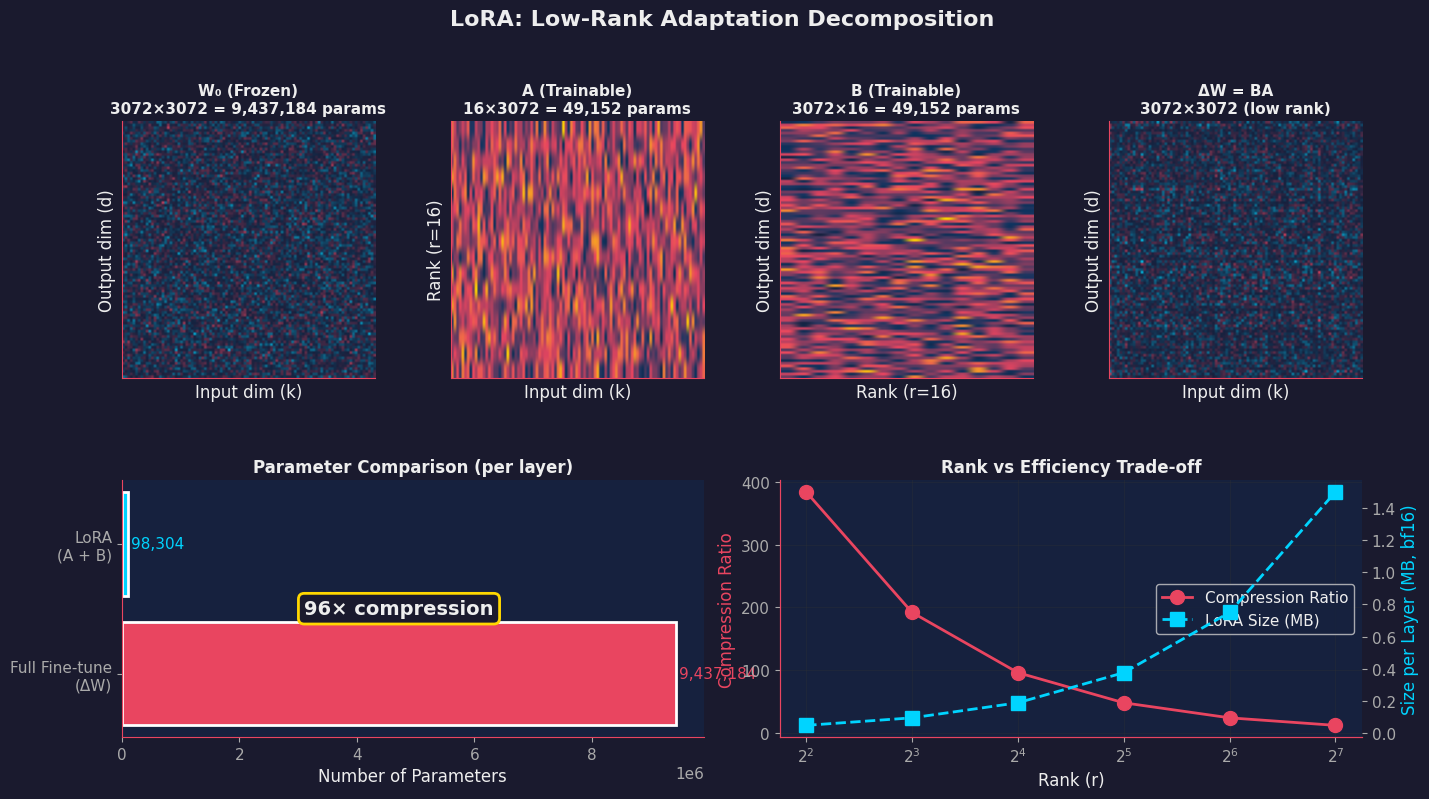


────────────────────────────────────────────────────────────
Klein Base 4B - Single Linear Layer Analysis
────────────────────────────────────────────────────────────
Full weight matrix:     3072 × 3072 =    9,437,184 parameters
LoRA (rank=16):         (16 × 3072) + (3072 × 16) =       98,304 parameters
Compression ratio:              96.0×
Memory savings:                99.0%


In [3]:
def visualize_lora_decomposition():
    """Visual explanation of the LoRA low-rank decomposition."""
    
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.3)
    
    # Dimensions for Klein Base 4B
    d, k = 3072, 3072  # Hidden size
    r = 16  # Rank
    
    # Create sample matrices for visualization (scaled down for display)
    scale_factor = 32
    d_vis, k_vis, r_vis = d // scale_factor, k // scale_factor, r
    
    np.random.seed(42)
    W0 = np.random.randn(d_vis, k_vis) * 0.02  # Pretrained weights
    A = np.random.randn(r_vis, k_vis) * 0.1    # LoRA A (Kaiming init)
    B = np.zeros((d_vis, r_vis))                # LoRA B (zero init)
    
    # After training
    B_trained = np.random.randn(d_vis, r_vis) * 0.05
    delta_W = B_trained @ A
    
    # Plot 1: Original weight matrix
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(W0, cmap=diverging_cmap, aspect='auto', vmin=-0.1, vmax=0.1)
    ax1.set_title(f'W₀ (Frozen)\n{d}×{k} = {d*k:,} params', fontsize=11)
    ax1.set_xlabel('Input dim (k)')
    ax1.set_ylabel('Output dim (d)')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Plot 2: LoRA A matrix
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(A, cmap=bfl_cmap, aspect='auto')
    ax2.set_title(f'A (Trainable)\n{r}×{k} = {r*k:,} params', fontsize=11)
    ax2.set_xlabel('Input dim (k)')
    ax2.set_ylabel(f'Rank (r={r})')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Plot 3: LoRA B matrix
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(B_trained, cmap=bfl_cmap, aspect='auto')
    ax3.set_title(f'B (Trainable)\n{d}×{r} = {d*r:,} params', fontsize=11)
    ax3.set_xlabel(f'Rank (r={r})')
    ax3.set_ylabel('Output dim (d)')
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # Plot 4: Delta W = BA
    ax4 = fig.add_subplot(gs[0, 3])
    im4 = ax4.imshow(delta_W, cmap=diverging_cmap, aspect='auto', vmin=-0.1, vmax=0.1)
    ax4.set_title(f'ΔW = BA\n{d}×{k} (low rank)', fontsize=11)
    ax4.set_xlabel('Input dim (k)')
    ax4.set_ylabel('Output dim (d)')
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    # Bottom row: Parameter comparison and compression visualization
    ax5 = fig.add_subplot(gs[1, :2])
    
    # Parameter counts
    full_params = d * k
    lora_params = r * k + d * r
    
    bars = ax5.barh(['Full Fine-tune\n(ΔW)', 'LoRA\n(A + B)'], 
                    [full_params, lora_params],
                    color=['#e94560', '#00d4ff'],
                    edgecolor='white',
                    linewidth=2)
    
    ax5.set_xlabel('Number of Parameters')
    ax5.set_title('Parameter Comparison (per layer)', fontsize=12)
    
    # Add text annotations
    ax5.text(full_params + 50000, 0, f'{full_params:,}', va='center', fontsize=11, color='#e94560')
    ax5.text(lora_params + 50000, 1, f'{lora_params:,}', va='center', fontsize=11, color='#00d4ff')
    ax5.text(full_params / 2, 0.5, f'{full_params / lora_params:.0f}× compression', 
             ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#1a1a2e', edgecolor='#ffd700', linewidth=2))
    
    # Rank analysis
    ax6 = fig.add_subplot(gs[1, 2:])
    
    ranks = [4, 8, 16, 32, 64, 128]
    compressions = [full_params / (r * k + d * r) for r in ranks]
    lora_sizes_mb = [(r * k + d * r) * 2 / (1024**2) for r in ranks]  # bf16
    
    ax6_twin = ax6.twinx()
    
    line1 = ax6.plot(ranks, compressions, 'o-', color='#e94560', linewidth=2, markersize=10, label='Compression Ratio')
    line2 = ax6_twin.plot(ranks, lora_sizes_mb, 's--', color='#00d4ff', linewidth=2, markersize=10, label='LoRA Size (MB)')
    
    ax6.set_xlabel('Rank (r)')
    ax6.set_ylabel('Compression Ratio', color='#e94560')
    ax6_twin.set_ylabel('Size per Layer (MB, bf16)', color='#00d4ff')
    ax6.set_title('Rank vs Efficiency Trade-off', fontsize=12)
    ax6.set_xscale('log', base=2)
    ax6.grid(True, alpha=0.3)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax6.legend(lines, labels, loc='center right')
    
    plt.suptitle('LoRA: Low-Rank Adaptation Decomposition', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'─' * 60}")
    print(f"Klein Base 4B - Single Linear Layer Analysis")
    print(f"{'─' * 60}")
    print(f"Full weight matrix:     {d} × {k} = {d*k:>12,} parameters")
    print(f"LoRA (rank={r}):         ({r} × {k}) + ({d} × {r}) = {r*k + d*r:>12,} parameters")
    print(f"Compression ratio:      {d*k / (r*k + d*r):>12.1f}×")
    print(f"Memory savings:         {(1 - (r*k + d*r) / (d*k)) * 100:>11.1f}%")

visualize_lora_decomposition()

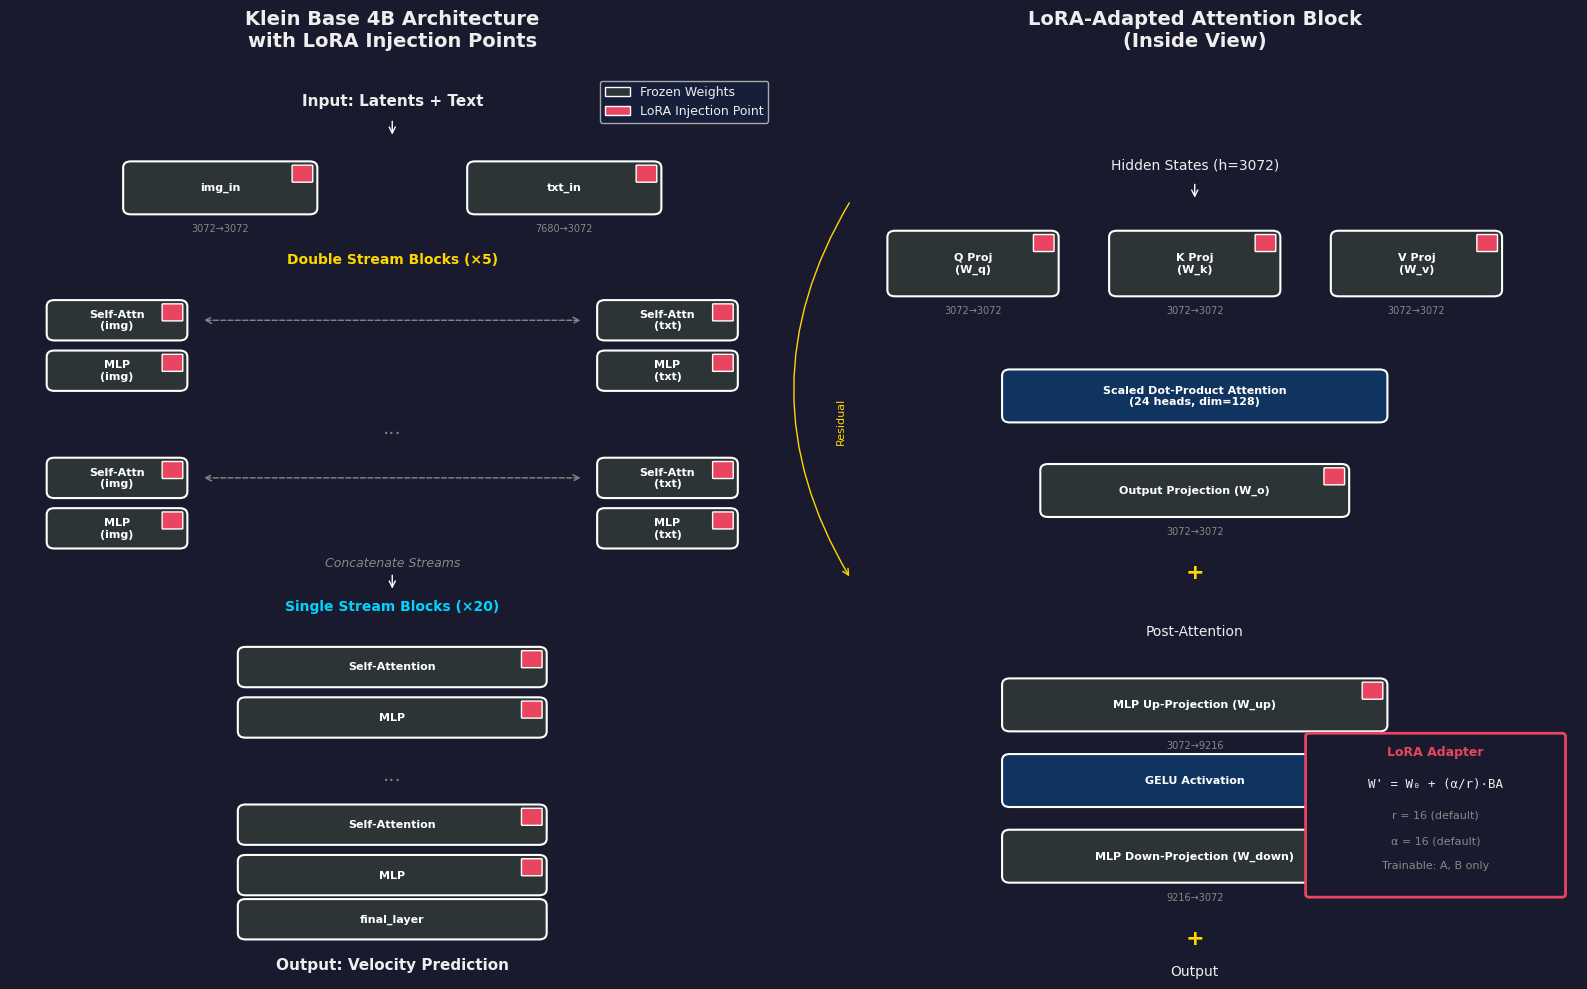

In [4]:
def visualize_klein_architecture():
    """Visualize Klein Base 4B architecture with LoRA injection points."""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    # Left: Architecture overview
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 14)
    ax1.axis('off')
    ax1.set_title('Klein Base 4B Architecture\nwith LoRA Injection Points', fontsize=14, pad=20)
    
    # Colors
    frozen_color = '#2d3436'
    lora_color = '#e94560'
    text_color = '#00d4ff'
    img_color = '#ffd700'
    
    def draw_block(ax, x, y, w, h, label, color, lora=False):
        rect = mpatches.FancyBboxPatch((x, y), w, h, 
                                        boxstyle="round,pad=0.02,rounding_size=0.1",
                                        facecolor=color, edgecolor='white', linewidth=1.5)
        ax.add_patch(rect)
        if lora:
            # Add LoRA indicator
            lora_rect = mpatches.FancyBboxPatch((x + w - 0.3, y + h - 0.3), 0.25, 0.25,
                                                 boxstyle="round,pad=0.01",
                                                 facecolor=lora_color, edgecolor='white', linewidth=1)
            ax.add_patch(lora_rect)
        ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', wrap=True)
    
    # Input
    ax1.text(5, 13.5, 'Input: Latents + Text', ha='center', fontsize=11, fontweight='bold')
    ax1.annotate('', xy=(5, 13), xytext=(5, 13.3), arrowprops=dict(arrowstyle='->', color='white'))
    
    # Input projections
    draw_block(ax1, 1.5, 11.8, 2.5, 0.8, 'img_in', frozen_color, lora=True)
    draw_block(ax1, 6, 11.8, 2.5, 0.8, 'txt_in', frozen_color, lora=True)
    ax1.text(2.75, 11.5, f'3072→3072', ha='center', fontsize=7, color='#888')
    ax1.text(7.25, 11.5, f'7680→3072', ha='center', fontsize=7, color='#888')
    
    # Double Stream Blocks
    ax1.text(5, 11, 'Double Stream Blocks (×5)', ha='center', fontsize=10, fontweight='bold', color=img_color)
    
    y_pos = 9.8
    for i in range(2):  # Show 2 representative blocks
        # Image stream
        draw_block(ax1, 0.5, y_pos, 1.8, 0.6, 'Self-Attn\n(img)', frozen_color, lora=True)
        draw_block(ax1, 0.5, y_pos - 0.8, 1.8, 0.6, 'MLP\n(img)', frozen_color, lora=True)
        
        # Text stream
        draw_block(ax1, 7.7, y_pos, 1.8, 0.6, 'Self-Attn\n(txt)', frozen_color, lora=True)
        draw_block(ax1, 7.7, y_pos - 0.8, 1.8, 0.6, 'MLP\n(txt)', frozen_color, lora=True)
        
        # Cross attention (conceptual)
        ax1.annotate('', xy=(2.5, y_pos + 0.3), xytext=(7.5, y_pos + 0.3),
                    arrowprops=dict(arrowstyle='<->', color='#888', ls='--'))
        
        y_pos -= 2
        if i == 0:
            ax1.text(5, y_pos + 0.5, '...', ha='center', fontsize=14, color='#888')
            y_pos -= 0.5
    
    # Merge point
    ax1.text(5, 6.2, 'Concatenate Streams', ha='center', fontsize=9, style='italic', color='#888')
    ax1.annotate('', xy=(5, 5.8), xytext=(5, 6.1), arrowprops=dict(arrowstyle='->', color='white'))
    
    # Single Stream Blocks
    ax1.text(5, 5.5, 'Single Stream Blocks (×20)', ha='center', fontsize=10, fontweight='bold', color=text_color)
    
    y_pos = 4.3
    for i in range(2):
        draw_block(ax1, 3, y_pos, 4, 0.6, 'Self-Attention', frozen_color, lora=True)
        draw_block(ax1, 3, y_pos - 0.8, 4, 0.6, 'MLP', frozen_color, lora=True)
        y_pos -= 2
        if i == 0:
            ax1.text(5, y_pos + 0.5, '...', ha='center', fontsize=14, color='#888')
            y_pos -= 0.5
    
    # Output
    draw_block(ax1, 3, 0.3, 4, 0.6, 'final_layer', frozen_color)
    ax1.text(5, -0.2, 'Output: Velocity Prediction', ha='center', fontsize=11, fontweight='bold')
    
    # Legend
    legend_y = 13
    legend_patches = [
        mpatches.Patch(facecolor=frozen_color, edgecolor='white', label='Frozen Weights'),
        mpatches.Patch(facecolor=lora_color, edgecolor='white', label='LoRA Injection Point'),
    ]
    ax1.legend(handles=legend_patches, loc='upper right', fontsize=9)
    
    # Right: Detailed block view
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 14)
    ax2.axis('off')
    ax2.set_title('LoRA-Adapted Attention Block\n(Inside View)', fontsize=14, pad=20)
    
    # Detailed attention block
    y = 12
    
    # Input
    ax2.text(5, y + 0.5, 'Hidden States (h=3072)', ha='center', fontsize=10)
    ax2.annotate('', xy=(5, y), xytext=(5, y + 0.3), arrowprops=dict(arrowstyle='->', color='white'))
    
    # QKV projection
    y -= 1.5
    draw_block(ax2, 1, y, 2.2, 1, 'Q Proj\n(W_q)', frozen_color, lora=True)
    draw_block(ax2, 3.9, y, 2.2, 1, 'K Proj\n(W_k)', frozen_color, lora=True)
    draw_block(ax2, 6.8, y, 2.2, 1, 'V Proj\n(W_v)', frozen_color, lora=True)
    
    # Dimensions
    ax2.text(2.1, y - 0.3, '3072→3072', ha='center', fontsize=7, color='#888')
    ax2.text(5, y - 0.3, '3072→3072', ha='center', fontsize=7, color='#888')
    ax2.text(7.9, y - 0.3, '3072→3072', ha='center', fontsize=7, color='#888')
    
    # Attention computation
    y -= 2
    draw_block(ax2, 2.5, y, 5, 0.8, 'Scaled Dot-Product Attention\n(24 heads, dim=128)', '#0f3460')
    
    # Output projection
    y -= 1.5
    draw_block(ax2, 3, y, 4, 0.8, 'Output Projection (W_o)', frozen_color, lora=True)
    ax2.text(5, y - 0.3, '3072→3072', ha='center', fontsize=7, color='#888')
    
    # Residual
    y -= 1.2
    ax2.text(5, y + 0.2, '+', ha='center', fontsize=16, fontweight='bold', color='#ffd700')
    ax2.annotate('', xy=(0.5, y + 0.2), xytext=(0.5, 12),
                arrowprops=dict(arrowstyle='->', color='#ffd700', connectionstyle='arc3,rad=0.3'))
    ax2.text(0.3, 8.5, 'Residual', rotation=90, fontsize=8, color='#ffd700', va='center')
    
    # MLP block
    y -= 1.2
    ax2.text(5, y + 0.5, 'Post-Attention', ha='center', fontsize=10)
    
    y -= 1
    draw_block(ax2, 2.5, y, 5, 0.8, 'MLP Up-Projection (W_up)', frozen_color, lora=True)
    ax2.text(5, y - 0.3, '3072→9216', ha='center', fontsize=7, color='#888')
    
    y -= 1.2
    draw_block(ax2, 2.5, y, 5, 0.8, 'GELU Activation', '#0f3460')
    
    y -= 1.2
    draw_block(ax2, 2.5, y, 5, 0.8, 'MLP Down-Projection (W_down)', frozen_color, lora=True)
    ax2.text(5, y - 0.3, '9216→3072', ha='center', fontsize=7, color='#888')
    
    # Output
    y -= 1.2
    ax2.text(5, y + 0.2, '+', ha='center', fontsize=16, fontweight='bold', color='#ffd700')
    ax2.text(5, y - 0.3, 'Output', ha='center', fontsize=10)
    
    # LoRA detail callout
    ax2.add_patch(mpatches.FancyBboxPatch((6.5, 1), 3.3, 2.5,
                                           boxstyle="round,pad=0.05",
                                           facecolor='#1a1a2e', edgecolor=lora_color, linewidth=2))
    ax2.text(8.15, 3.2, 'LoRA Adapter', ha='center', fontsize=9, fontweight='bold', color=lora_color)
    ax2.text(8.15, 2.7, 'W\' = W₀ + (α/r)·BA', ha='center', fontsize=9, fontfamily='monospace')
    ax2.text(8.15, 2.2, 'r = 16 (default)', ha='center', fontsize=8, color='#888')
    ax2.text(8.15, 1.8, 'α = 16 (default)', ha='center', fontsize=8, color='#888')
    ax2.text(8.15, 1.4, 'Trainable: A, B only', ha='center', fontsize=8, color='#888')
    
    plt.tight_layout()
    plt.show()

visualize_klein_architecture()

In [5]:
# Demonstrate parameter efficiency for Klein Base 4B dimensions
klein_4b_config = {
    'hidden_size': 3072,
    'num_heads': 24,
    'head_dim': 128,  # 3072 / 24
    'mlp_dim': 9216,  # 3072 * 3 (mlp_ratio=3.0)
    'depth': 5,       # double blocks
    'depth_single': 20,  # single blocks
}

def compute_lora_params(config: dict, rank: int, target_modules: List[str]) -> Dict[str, int]:
    """Calculate LoRA parameters for different target modules."""
    h = config['hidden_size']
    mlp = config['mlp_dim']
    n_double = config['depth']
    n_single = config['depth_single']
    
    # Per-layer parameter counts
    layer_params = {
        'qkv': 3 * h * h,      # Q, K, V projections
        'out_proj': h * h,     # Output projection
        'mlp_up': h * mlp,     # MLP up-projection
        'mlp_down': mlp * h,   # MLP down-projection
    }
    
    # LoRA params per layer (rank * (in + out))
    lora_params = {
        'qkv': 3 * rank * (h + h),
        'out_proj': rank * (h + h),
        'mlp_up': rank * (h + mlp),
        'mlp_down': rank * (mlp + h),
    }
    
    total_base = 0
    total_lora = 0
    
    # Count for double stream blocks (2x for img/txt streams)
    for module in target_modules:
        if module in layer_params:
            total_base += layer_params[module] * n_double * 2
            total_lora += lora_params[module] * n_double * 2
    
    # Count for single stream blocks
    for module in target_modules:
        if module in layer_params:
            total_base += layer_params[module] * n_single
            total_lora += lora_params[module] * n_single
    
    return {
        'base_params': total_base,
        'lora_params': total_lora,
        'compression_ratio': total_base / total_lora if total_lora > 0 else float('inf'),
        'lora_mb': total_lora * 2 / (1024**2),  # bf16
    }

# Compare different configurations
configs = [
    ('Attention only (r=8)', 8, ['qkv', 'out_proj']),
    ('Attention only (r=32)', 32, ['qkv', 'out_proj']),
    ('Attention + MLP (r=8)', 8, ['qkv', 'out_proj', 'mlp_up', 'mlp_down']),
    ('Attention + MLP (r=32)', 32, ['qkv', 'out_proj', 'mlp_up', 'mlp_down']),
    ('Full (r=64)', 64, ['qkv', 'out_proj', 'mlp_up', 'mlp_down']),
]

print("LoRA Configuration Analysis for Klein Base 4B")
print("=" * 70)
print(f"{'Configuration':<30} {'LoRA Params':>12} {'Size (MB)':>10} {'Ratio':>10}")
print("-" * 70)

for name, rank, modules in configs:
    stats = compute_lora_params(klein_4b_config, rank, modules)
    print(f"{name:<30} {stats['lora_params']:>12,} {stats['lora_mb']:>10.2f} {stats['compression_ratio']:>10.1f}x")

LoRA Configuration Analysis for Klein Base 4B
Configuration                   LoRA Params  Size (MB)      Ratio
----------------------------------------------------------------------
Attention only (r=8)              5,898,240      11.25      192.0x
Attention only (r=32)            23,592,960      45.00       48.0x
Attention + MLP (r=8)            11,796,480      22.50      240.0x
Attention + MLP (r=32)           47,185,920      90.00       60.0x
Full (r=64)                      94,371,840     180.00       30.0x


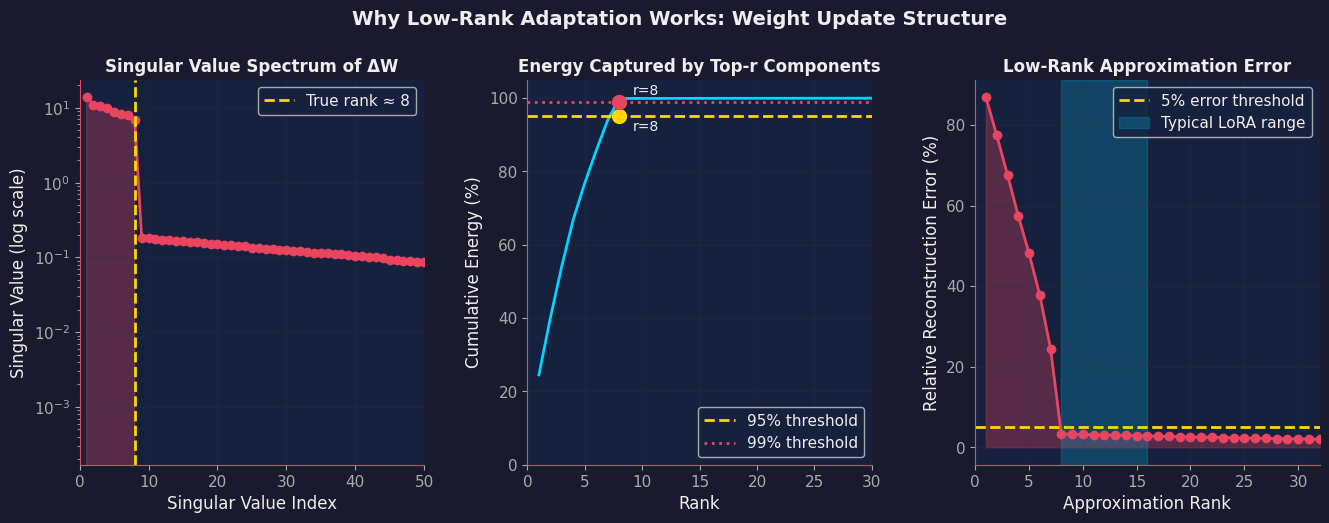


──────────────────────────────────────────────────────────────────────
Key Insight: Fine-tuning updates are approximately low-rank!
──────────────────────────────────────────────────────────────────────
• 95% of information captured with rank 8
• 99% of information captured with rank 8
• This is why LoRA works: we're not losing much by constraining rank
• Practical LoRA ranks (8-32) capture most meaningful adaptation


In [6]:
def visualize_why_lowrank_works():
    """Demonstrate why low-rank approximation is effective for fine-tuning."""
    
    fig = plt.figure(figsize=(16, 5))
    gs = GridSpec(1, 3, figure=fig, wspace=0.3)
    
    # Simulate weight update matrix from fine-tuning
    np.random.seed(42)
    d, k = 100, 100
    
    # Create a realistic delta W: most change in a low-dimensional subspace
    # This mimics what happens in practice during fine-tuning
    true_rank = 8
    U = np.random.randn(d, true_rank)
    V = np.random.randn(true_rank, k)
    delta_W_lowrank = U @ V * 0.1
    
    # Add some noise (full-rank but small)
    noise = np.random.randn(d, k) * 0.01
    delta_W = delta_W_lowrank + noise
    
    # SVD analysis
    U_svd, s, Vh = np.linalg.svd(delta_W)
    
    # Plot 1: Singular value spectrum
    ax1 = fig.add_subplot(gs[0])
    ax1.semilogy(range(1, len(s) + 1), s, 'o-', color='#e94560', linewidth=2, markersize=6)
    ax1.axvline(x=true_rank, color='#ffd700', linestyle='--', linewidth=2, label=f'True rank ≈ {true_rank}')
    ax1.fill_between(range(1, true_rank + 1), s[:true_rank], alpha=0.3, color='#e94560')
    ax1.set_xlabel('Singular Value Index')
    ax1.set_ylabel('Singular Value (log scale)')
    ax1.set_title('Singular Value Spectrum of ΔW', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 50)
    
    # Plot 2: Cumulative energy
    ax2 = fig.add_subplot(gs[1])
    energy = np.cumsum(s**2) / np.sum(s**2) * 100
    ax2.plot(range(1, len(energy) + 1), energy, '-', color='#00d4ff', linewidth=2)
    ax2.axhline(y=95, color='#ffd700', linestyle='--', linewidth=2, label='95% threshold')
    ax2.axhline(y=99, color='#e94560', linestyle=':', linewidth=2, label='99% threshold')
    
    # Find ranks for thresholds
    rank_95 = np.argmax(energy >= 95) + 1
    rank_99 = np.argmax(energy >= 99) + 1
    ax2.scatter([rank_95], [95], s=100, color='#ffd700', zorder=5)
    ax2.scatter([rank_99], [99], s=100, color='#e94560', zorder=5)
    ax2.annotate(f'r={rank_95}', (rank_95, 95), textcoords="offset points", xytext=(10, -10), fontsize=10)
    ax2.annotate(f'r={rank_99}', (rank_99, 99), textcoords="offset points", xytext=(10, 5), fontsize=10)
    
    ax2.set_xlabel('Rank')
    ax2.set_ylabel('Cumulative Energy (%)')
    ax2.set_title('Energy Captured by Top-r Components', fontsize=12)
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 30)
    ax2.set_ylim(0, 105)
    
    # Plot 3: Reconstruction error
    ax3 = fig.add_subplot(gs[2])
    ranks = range(1, 33)
    errors = []
    for r in ranks:
        # Reconstruct with rank r
        reconstruction = U_svd[:, :r] @ np.diag(s[:r]) @ Vh[:r, :]
        error = np.linalg.norm(delta_W - reconstruction, 'fro') / np.linalg.norm(delta_W, 'fro')
        errors.append(error * 100)
    
    ax3.plot(ranks, errors, 'o-', color='#e94560', linewidth=2, markersize=6)
    ax3.axhline(y=5, color='#ffd700', linestyle='--', linewidth=2, label='5% error threshold')
    ax3.fill_between(ranks, errors, alpha=0.3, color='#e94560')
    
    # Highlight practical range
    ax3.axvspan(8, 16, alpha=0.2, color='#00d4ff', label='Typical LoRA range')
    
    ax3.set_xlabel('Approximation Rank')
    ax3.set_ylabel('Relative Reconstruction Error (%)')
    ax3.set_title('Low-Rank Approximation Error', fontsize=12)
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 32)
    
    plt.suptitle('Why Low-Rank Adaptation Works: Weight Update Structure', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "─" * 70)
    print("Key Insight: Fine-tuning updates are approximately low-rank!")
    print("─" * 70)
    print(f"• 95% of information captured with rank {rank_95}")
    print(f"• 99% of information captured with rank {rank_99}")
    print("• This is why LoRA works: we're not losing much by constraining rank")
    print("• Practical LoRA ranks (8-32) capture most meaningful adaptation")

visualize_why_lowrank_works()

### 1.2 Why LoRA Works Differently in Diffusion Models

Diffusion models present unique challenges for LoRA:

**1. Timestep-Dependent Behavior**
- The model operates across a continuum of noise levels
- Early timesteps (high noise): coarse structure, global composition
- Late timesteps (low noise): fine details, textures
- LoRA must generalize across ALL timesteps, not just a single forward pass

**2. Classifier-Free Guidance Interaction**
- CFG amplifies the difference between conditional and unconditional predictions
- LoRA changes both predictions, so its effect is also amplified
- Higher guidance = stronger LoRA effect (can lead to artifacts)

**3. Multi-Modal Conditioning**
- Text embeddings interact with image latents through cross-attention
- LoRA on attention layers affects text-image binding
- LoRA on MLP affects feature transformation independently

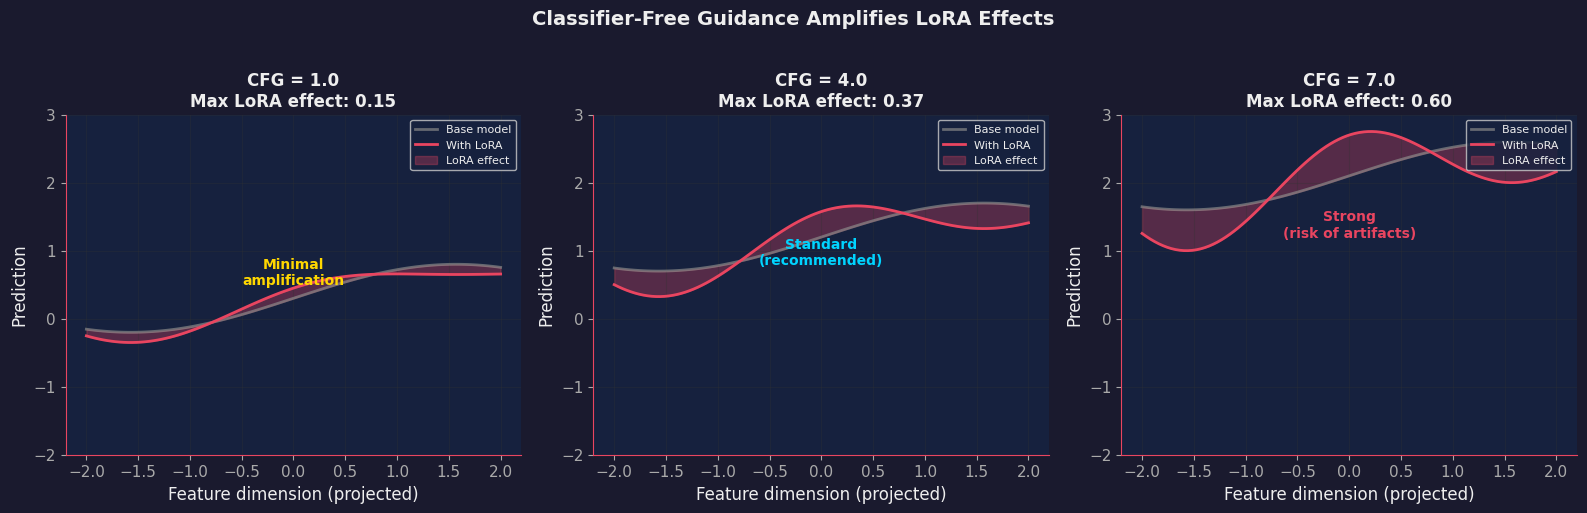

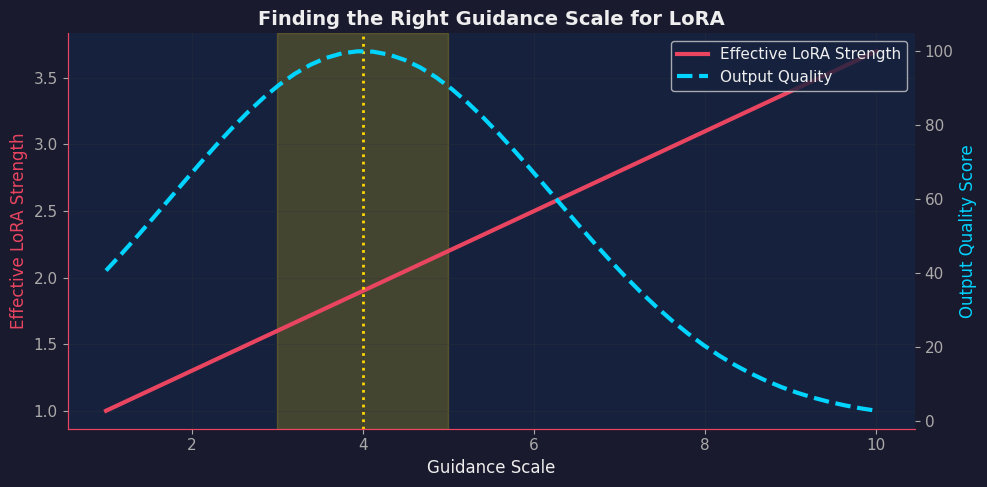


──────────────────────────────────────────────────────────────────────
CFG-LoRA Interaction Guidelines:
──────────────────────────────────────────────────────────────────────
• Higher CFG = stronger LoRA effect (can cause oversaturation)
• Recommended: Start with guidance=4.0 for Klein Base
• If LoRA effect too strong: reduce guidance OR reduce alpha/rank ratio
• If LoRA effect too weak: increase guidance slightly (up to 6-7)


In [7]:
def visualize_cfg_lora_interaction():
    """Visualize how CFG amplifies LoRA effects."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Simulate predictions
    np.random.seed(42)
    
    # Base model predictions (1D projection for visualization)
    x = np.linspace(-2, 2, 100)
    
    # Unconditional prediction (no text)
    pred_uncond_base = np.sin(x) * 0.5
    
    # Conditional prediction (with text)
    pred_cond_base = np.sin(x) * 0.5 + 0.3
    
    # LoRA effect: shifts both predictions
    lora_effect = 0.15 * np.cos(x * 2)
    pred_uncond_lora = pred_uncond_base + lora_effect * 0.5
    pred_cond_lora = pred_cond_base + lora_effect
    
    # CFG formula: pred = pred_uncond + guidance * (pred_cond - pred_uncond)
    guidances = [1.0, 4.0, 7.0]
    
    for idx, guidance in enumerate(guidances):
        ax = axes[idx]
        
        # Base model with CFG
        pred_base_cfg = pred_uncond_base + guidance * (pred_cond_base - pred_uncond_base)
        
        # LoRA model with CFG
        pred_lora_cfg = pred_uncond_lora + guidance * (pred_cond_lora - pred_uncond_lora)
        
        # Plot
        ax.plot(x, pred_base_cfg, '-', color='#888', linewidth=2, label='Base model', alpha=0.7)
        ax.plot(x, pred_lora_cfg, '-', color='#e94560', linewidth=2, label='With LoRA')
        ax.fill_between(x, pred_base_cfg, pred_lora_cfg, alpha=0.3, color='#e94560', label='LoRA effect')
        
        # Show the difference magnitude
        diff = np.abs(pred_lora_cfg - pred_base_cfg)
        max_diff = np.max(diff)
        
        ax.set_xlabel('Feature dimension (projected)')
        ax.set_ylabel('Prediction')
        ax.set_title(f'CFG = {guidance:.1f}\nMax LoRA effect: {max_diff:.2f}', fontsize=12)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-2, 3)
        
        # Add annotation
        if idx == 0:
            ax.annotate('Minimal\namplification', xy=(0, 0.5), fontsize=10,
                       ha='center', color='#ffd700', fontweight='bold')
        elif idx == 1:
            ax.annotate('Standard\n(recommended)', xy=(0, 0.8), fontsize=10,
                       ha='center', color='#00d4ff', fontweight='bold')
        else:
            ax.annotate('Strong\n(risk of artifacts)', xy=(0, 1.2), fontsize=10,
                       ha='center', color='#e94560', fontweight='bold')
    
    plt.suptitle('Classifier-Free Guidance Amplifies LoRA Effects', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: LoRA effect vs guidance scale
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    
    guidance_range = np.linspace(1, 10, 50)
    
    # Simulate effective LoRA strength at different guidance values
    base_lora_strength = 1.0
    effective_strength = base_lora_strength * (1 + (guidance_range - 1) * 0.3)
    
    # Quality curve (peaks around optimal guidance, degrades at extremes)
    quality = 100 * np.exp(-((guidance_range - 4) ** 2) / 10)
    
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(guidance_range, effective_strength, '-', color='#e94560', linewidth=3, label='Effective LoRA Strength')
    line2 = ax2_twin.plot(guidance_range, quality, '--', color='#00d4ff', linewidth=3, label='Output Quality')
    
    # Optimal region
    ax2.axvspan(3, 5, alpha=0.2, color='#ffd700', label='Optimal range')
    ax2.axvline(x=4, color='#ffd700', linestyle=':', linewidth=2)
    
    ax2.set_xlabel('Guidance Scale', fontsize=12)
    ax2.set_ylabel('Effective LoRA Strength', color='#e94560', fontsize=12)
    ax2_twin.set_ylabel('Output Quality Score', color='#00d4ff', fontsize=12)
    ax2.set_title('Finding the Right Guidance Scale for LoRA', fontsize=14)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "─" * 70)
    print("CFG-LoRA Interaction Guidelines:")
    print("─" * 70)
    print("• Higher CFG = stronger LoRA effect (can cause oversaturation)")
    print("• Recommended: Start with guidance=4.0 for Klein Base")
    print("• If LoRA effect too strong: reduce guidance OR reduce alpha/rank ratio")
    print("• If LoRA effect too weak: increase guidance slightly (up to 6-7)")

visualize_cfg_lora_interaction()

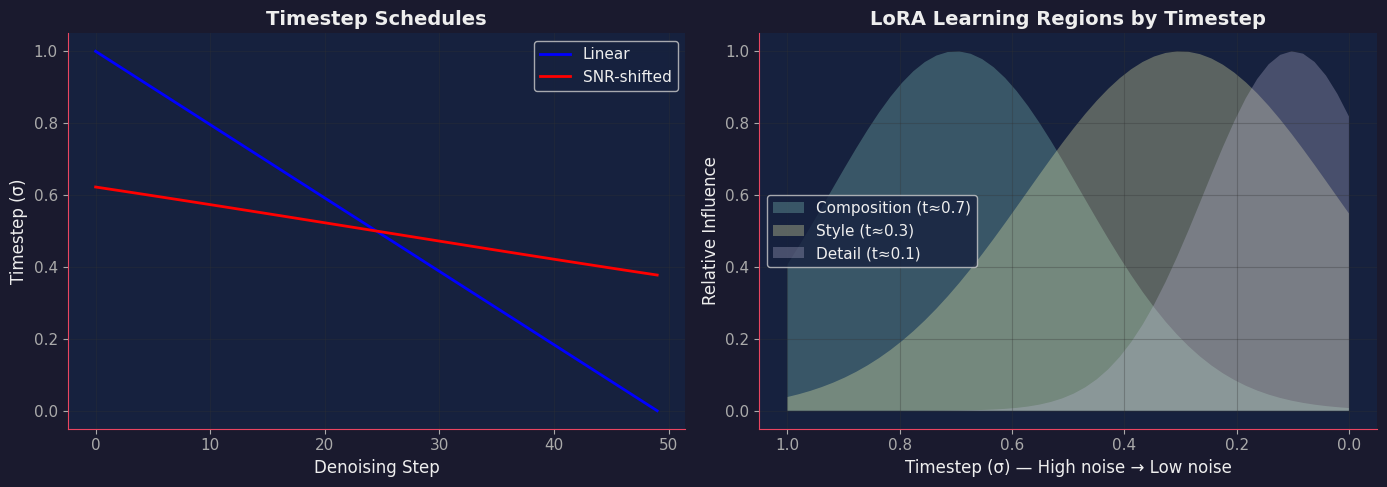


Key Insight:
- Style LoRAs primarily operate at intermediate timesteps (t ≈ 0.2-0.5)
- Subject/character LoRAs need influence at early timesteps for composition
- Detail/texture LoRAs activate at late timesteps (t < 0.1)


In [8]:
def visualize_lora_effect_over_timesteps():
    """Illustrate how LoRA effect varies across denoising timesteps."""
    
    # Simulate timestep schedule (FLUX uses SNR-shifted schedule)
    num_steps = 50
    timesteps = np.linspace(1, 0, num_steps)
    
    # SNR shift approximation
    mu = 0.5
    sigma = 1.0
    timesteps_shifted = 1 / (1 + np.exp(-((timesteps - mu) / sigma)))
    
    # Hypothetical LoRA influence (higher at intermediate timesteps)
    # This is conceptual - actual influence depends on training data
    lora_influence_composition = np.exp(-((timesteps - 0.7)**2) / 0.1)  # Early: composition
    lora_influence_style = np.exp(-((timesteps - 0.3)**2) / 0.15)       # Mid: style
    lora_influence_detail = np.exp(-((timesteps - 0.1)**2) / 0.05)      # Late: detail
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Timestep schedule
    ax1 = axes[0]
    ax1.plot(range(num_steps), timesteps, 'b-', label='Linear', linewidth=2)
    ax1.plot(range(num_steps), timesteps_shifted, 'r-', label='SNR-shifted', linewidth=2)
    ax1.set_xlabel('Denoising Step')
    ax1.set_ylabel('Timestep (σ)')
    ax1.set_title('Timestep Schedules')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: LoRA influence regions
    ax2 = axes[1]
    ax2.fill_between(timesteps, lora_influence_composition, alpha=0.3, label='Composition (t≈0.7)')
    ax2.fill_between(timesteps, lora_influence_style, alpha=0.3, label='Style (t≈0.3)')
    ax2.fill_between(timesteps, lora_influence_detail, alpha=0.3, label='Detail (t≈0.1)')
    ax2.set_xlabel('Timestep (σ) — High noise → Low noise')
    ax2.set_ylabel('Relative Influence')
    ax2.set_title('LoRA Learning Regions by Timestep')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insight:")
    print("- Style LoRAs primarily operate at intermediate timesteps (t ≈ 0.2-0.5)")
    print("- Subject/character LoRAs need influence at early timesteps for composition")
    print("- Detail/texture LoRAs activate at late timesteps (t < 0.1)")

visualize_lora_effect_over_timesteps()

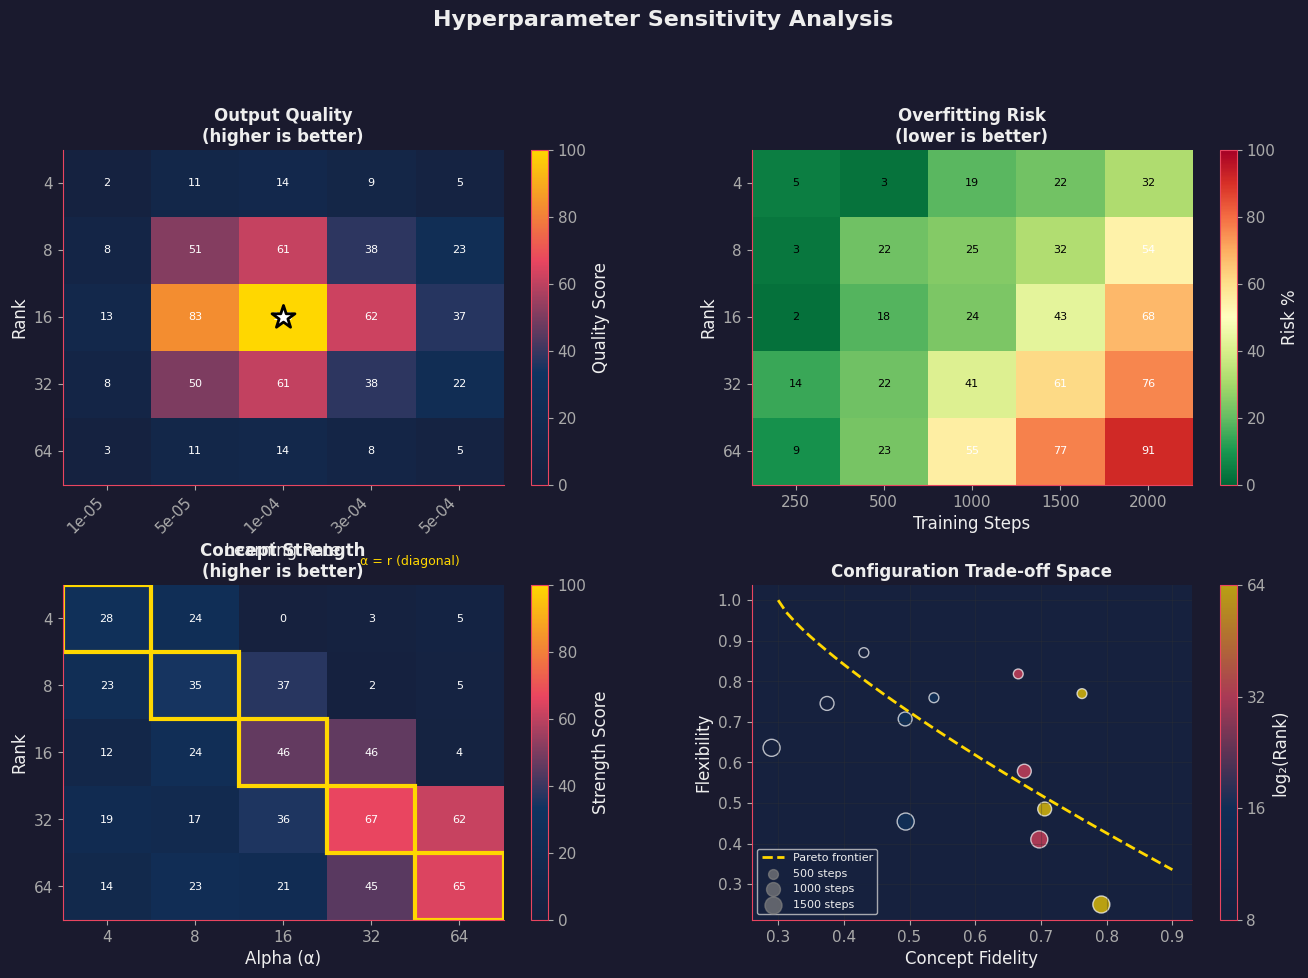


──────────────────────────────────────────────────────────────────────
Hyperparameter Recommendations for Klein Base 4B:
──────────────────────────────────────────────────────────────────────
• Rank: 16 (balanced) | 8 (efficiency) | 32+ (complex concepts)
• Alpha: Start with α = r, increase to 2r if effect too weak
• Learning Rate: 1e-4 to 3e-4 (sweet spot)
• Steps: 500-1000 (avoid >1500 unless large dataset)


In [9]:
def visualize_hyperparameter_sensitivity():
    """Create heatmaps showing hyperparameter sensitivity."""
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    # Hyperparameter ranges
    ranks = [4, 8, 16, 32, 64]
    learning_rates = [1e-5, 5e-5, 1e-4, 3e-4, 5e-4]
    steps = [250, 500, 1000, 1500, 2000]
    alphas = [4, 8, 16, 32, 64]
    
    # Simulated quality metrics (based on typical behavior)
    np.random.seed(42)
    
    # Quality = f(rank, lr) - peaks at moderate values
    def quality_rank_lr(r, lr):
        # Optimal around rank=16-32, lr=1e-4 to 3e-4
        r_score = np.exp(-((np.log2(r) - 4) ** 2) / 2)  # Peak at r=16
        lr_score = np.exp(-((np.log10(lr) + 4) ** 2) / 0.5)  # Peak at 1e-4
        noise = np.random.randn() * 0.05
        return np.clip(r_score * lr_score * 100 + noise * 10, 0, 100)
    
    # Overfitting risk = f(rank, steps)
    def overfit_risk(r, s):
        # Higher rank and more steps = more overfitting
        risk = (np.log2(r) / 6) * (s / 2000) * 100
        noise = np.random.randn() * 5
        return np.clip(risk + noise, 0, 100)
    
    # Concept strength = f(rank, alpha)
    def concept_strength(r, a):
        # Higher when alpha/r is around 1-2
        ratio = a / r
        strength = np.exp(-((ratio - 1.5) ** 2) / 1) * np.log2(r) / 6 * 100
        noise = np.random.randn() * 5
        return np.clip(strength + noise, 0, 100)
    
    # Flexibility = f(rank, steps) - inverse of overfitting
    def flexibility(r, s):
        return 100 - overfit_risk(r, s)
    
    # Plot 1: Quality vs Rank and Learning Rate
    ax1 = fig.add_subplot(gs[0, 0])
    quality_matrix = np.array([[quality_rank_lr(r, lr) for lr in learning_rates] for r in ranks])
    im1 = ax1.imshow(quality_matrix, cmap=bfl_cmap, aspect='auto', vmin=0, vmax=100)
    ax1.set_xticks(range(len(learning_rates)))
    ax1.set_xticklabels([f'{lr:.0e}' for lr in learning_rates], rotation=45, ha='right')
    ax1.set_yticks(range(len(ranks)))
    ax1.set_yticklabels(ranks)
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Rank')
    ax1.set_title('Output Quality\n(higher is better)', fontsize=12)
    plt.colorbar(im1, ax=ax1, label='Quality Score')
    
    # Add best region marker
    best_idx = np.unravel_index(np.argmax(quality_matrix), quality_matrix.shape)
    ax1.scatter(best_idx[1], best_idx[0], marker='*', s=300, color='white', edgecolor='black', linewidth=2, zorder=5)
    
    # Add values to cells
    for i in range(len(ranks)):
        for j in range(len(learning_rates)):
            ax1.text(j, i, f'{quality_matrix[i, j]:.0f}', ha='center', va='center', fontsize=8, color='white')
    
    # Plot 2: Overfitting Risk vs Rank and Steps
    ax2 = fig.add_subplot(gs[0, 1])
    overfit_matrix = np.array([[overfit_risk(r, s) for s in steps] for r in ranks])
    im2 = ax2.imshow(overfit_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=100)
    ax2.set_xticks(range(len(steps)))
    ax2.set_xticklabels(steps)
    ax2.set_yticks(range(len(ranks)))
    ax2.set_yticklabels(ranks)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Rank')
    ax2.set_title('Overfitting Risk\n(lower is better)', fontsize=12)
    plt.colorbar(im2, ax=ax2, label='Risk %')
    
    for i in range(len(ranks)):
        for j in range(len(steps)):
            color = 'white' if overfit_matrix[i, j] > 50 else 'black'
            ax2.text(j, i, f'{overfit_matrix[i, j]:.0f}', ha='center', va='center', fontsize=8, color=color)
    
    # Plot 3: Concept Strength vs Rank and Alpha
    ax3 = fig.add_subplot(gs[1, 0])
    concept_matrix = np.array([[concept_strength(r, a) for a in alphas] for r in ranks])
    im3 = ax3.imshow(concept_matrix, cmap=bfl_cmap, aspect='auto', vmin=0, vmax=100)
    ax3.set_xticks(range(len(alphas)))
    ax3.set_xticklabels(alphas)
    ax3.set_yticks(range(len(ranks)))
    ax3.set_yticklabels(ranks)
    ax3.set_xlabel('Alpha (α)')
    ax3.set_ylabel('Rank')
    ax3.set_title('Concept Strength\n(higher is better)', fontsize=12)
    plt.colorbar(im3, ax=ax3, label='Strength Score')
    
    # Mark diagonal (alpha = rank)
    for i in range(min(len(ranks), len(alphas))):
        ax3.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, edgecolor='#ffd700', linewidth=3))
    ax3.text(len(alphas)-1, -0.8, 'α = r (diagonal)', fontsize=9, color='#ffd700', ha='right')
    
    for i in range(len(ranks)):
        for j in range(len(alphas)):
            ax3.text(j, i, f'{concept_matrix[i, j]:.0f}', ha='center', va='center', fontsize=8, color='white')
    
    # Plot 4: Trade-off summary scatter
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Generate points for different configurations
    configs_data = []
    config_labels = []
    for r in [8, 16, 32, 64]:
        for s in [500, 1000, 1500]:
            fidelity = concept_strength(r, r) / 100
            flex = flexibility(r, s) / 100
            configs_data.append((fidelity, flex, r, s))
    
    fidelities = [c[0] for c in configs_data]
    flexibilities = [c[1] for c in configs_data]
    ranks_scatter = [c[2] for c in configs_data]
    steps_scatter = [c[3] for c in configs_data]
    
    # Color by rank, size by steps
    scatter = ax4.scatter(fidelities, flexibilities, 
                         c=np.log2(ranks_scatter), cmap=bfl_cmap,
                         s=[s/10 for s in steps_scatter],
                         alpha=0.7, edgecolors='white', linewidth=1)
    
    # Add Pareto frontier
    x_pareto = np.linspace(0.3, 0.9, 50)
    y_pareto = 1 - (x_pareto - 0.3) ** 0.8
    ax4.plot(x_pareto, y_pareto, '--', color='#ffd700', linewidth=2, label='Pareto frontier')
    
    ax4.set_xlabel('Concept Fidelity')
    ax4.set_ylabel('Flexibility')
    ax4.set_title('Configuration Trade-off Space', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar for rank
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('log₂(Rank)')
    cbar.set_ticks([3, 4, 5, 6])
    cbar.set_ticklabels(['8', '16', '32', '64'])
    
    # Size legend
    ax4.scatter([], [], s=50, c='gray', alpha=0.7, label='500 steps')
    ax4.scatter([], [], s=100, c='gray', alpha=0.7, label='1000 steps')
    ax4.scatter([], [], s=150, c='gray', alpha=0.7, label='1500 steps')
    ax4.legend(loc='lower left', fontsize=8)
    
    plt.suptitle('Hyperparameter Sensitivity Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "─" * 70)
    print("Hyperparameter Recommendations for Klein Base 4B:")
    print("─" * 70)
    print("• Rank: 16 (balanced) | 8 (efficiency) | 32+ (complex concepts)")
    print("• Alpha: Start with α = r, increase to 2r if effect too weak")
    print("• Learning Rate: 1e-4 to 3e-4 (sweet spot)")
    print("• Steps: 500-1000 (avoid >1500 unless large dataset)")

visualize_hyperparameter_sensitivity()

### 1.3 Flow Matching vs. DDPM: Implications for LoRA

FLUX.2 uses **flow matching** (also called rectified flow), which differs from traditional DDPM:

| Aspect | DDPM | Flow Matching |
|--------|------|---------------|
| Forward process | Gaussian noise schedule | Linear interpolation |
| Prediction target | $\epsilon$ (noise) | $v$ (velocity) |
| Training objective | $\|\epsilon - \epsilon_\theta\|^2$ | $\|v - v_\theta\|^2$ |
| Timestep range | Discrete (1000 steps) | Continuous [0, 1] |
| Inference | Ancestral sampling | ODE integration |

**Why this matters for LoRA:**
- Velocity prediction creates smoother gradients during training
- Continuous timesteps mean LoRA must interpolate behavior
- Fewer artifacts from discrete timestep boundaries

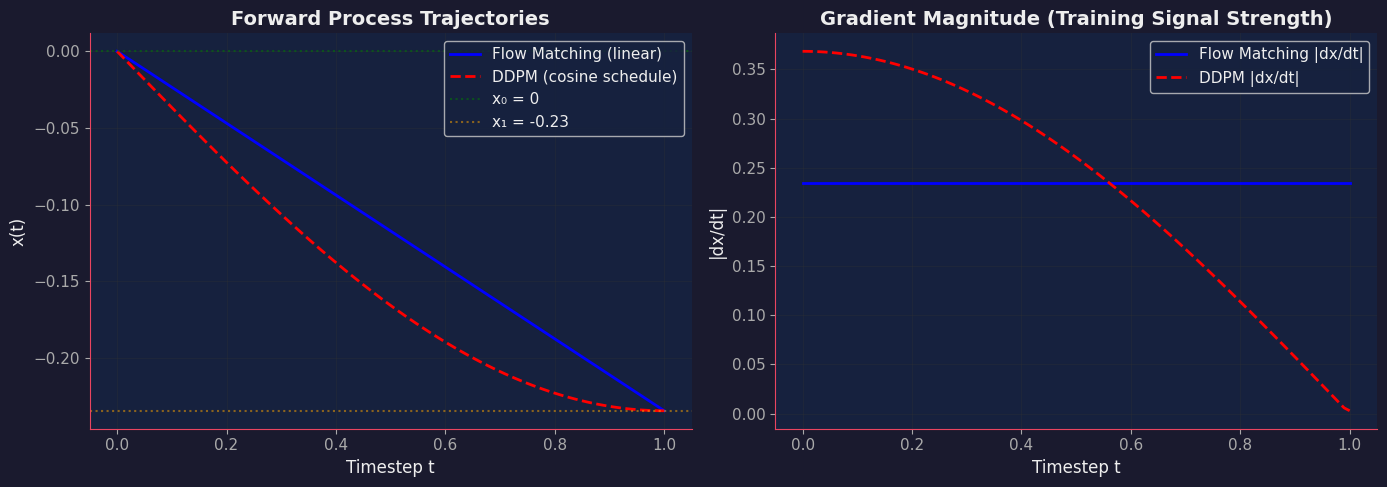


Key Differences for LoRA Training:
- Flow matching: constant gradient magnitude → uniform learning across timesteps
- DDPM: varying gradient magnitude → uneven learning, requires loss weighting
- Flow matching is generally more stable for fine-tuning


In [10]:
def compare_training_objectives():
    """Compare DDPM noise prediction vs flow matching velocity prediction."""
    
    # Simulate a simple 1D trajectory
    t = np.linspace(0, 1, 100)
    x0 = 0  # Data point
    x1 = np.random.randn()  # Noise sample
    
    # Flow matching: linear interpolation
    x_t_flow = (1 - t) * x0 + t * x1
    v_target = x1 - x0  # Constant velocity
    
    # DDPM: noise schedule (simplified)
    alpha_t = np.cos(t * np.pi / 2) ** 2
    sigma_t = np.sin(t * np.pi / 2)
    x_t_ddpm = np.sqrt(alpha_t) * x0 + sigma_t * x1
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    ax1.plot(t, x_t_flow, 'b-', label='Flow Matching (linear)', linewidth=2)
    ax1.plot(t, x_t_ddpm, 'r--', label='DDPM (cosine schedule)', linewidth=2)
    ax1.axhline(y=x0, color='g', linestyle=':', alpha=0.5, label=f'x₀ = {x0}')
    ax1.axhline(y=x1, color='orange', linestyle=':', alpha=0.5, label=f'x₁ = {x1:.2f}')
    ax1.set_xlabel('Timestep t')
    ax1.set_ylabel('x(t)')
    ax1.set_title('Forward Process Trajectories')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gradient magnitudes
    dx_flow = np.gradient(x_t_flow, t)
    dx_ddpm = np.gradient(x_t_ddpm, t)
    
    ax2 = axes[1]
    ax2.plot(t, np.abs(dx_flow), 'b-', label='Flow Matching |dx/dt|', linewidth=2)
    ax2.plot(t, np.abs(dx_ddpm), 'r--', label='DDPM |dx/dt|', linewidth=2)
    ax2.set_xlabel('Timestep t')
    ax2.set_ylabel('|dx/dt|')
    ax2.set_title('Gradient Magnitude (Training Signal Strength)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Differences for LoRA Training:")
    print("- Flow matching: constant gradient magnitude → uniform learning across timesteps")
    print("- DDPM: varying gradient magnitude → uneven learning, requires loss weighting")
    print("- Flow matching is generally more stable for fine-tuning")

compare_training_objectives()

---
## Part 2: Hyperparameter Selection for Image LoRAs

### 2.1 The Rank-Alpha Relationship

The effective learning rate for LoRA is modulated by the ratio $\frac{\alpha}{r}$:

$$\Delta W = \frac{\alpha}{r} \cdot B A$$

**Common conventions:**
- $\alpha = r$ → scaling factor = 1 (neutral)
- $\alpha = 2r$ → scaling factor = 2 (aggressive)
- $\alpha = r/2$ → scaling factor = 0.5 (conservative)

**For image models, we generally recommend:**
- Start with $\alpha = r$ or $\alpha = 2r$
- Adjust based on convergence speed and overfitting

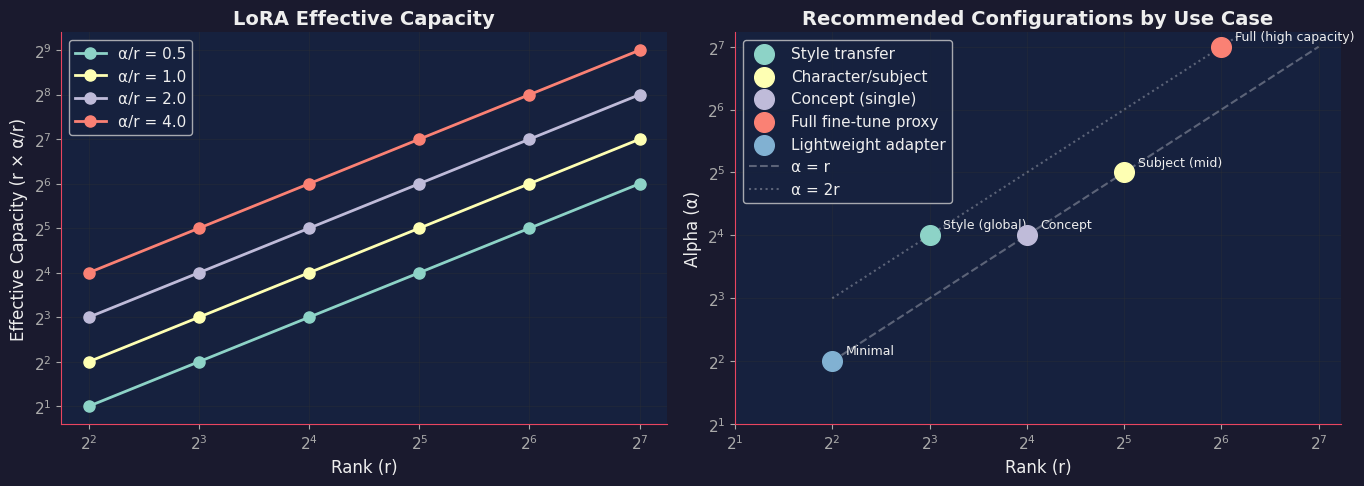

In [11]:
def analyze_rank_alpha_tradeoffs():
    """Visualize the rank-alpha parameter space."""
    
    ranks = [4, 8, 16, 32, 64, 128]
    alpha_ratios = [0.5, 1.0, 2.0, 4.0]
    
    # Create heatmap data
    # Effective capacity ≈ rank × scaling factor
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Effective capacity
    ax1 = axes[0]
    for ratio in alpha_ratios:
        effective_capacity = [r * ratio for r in ranks]
        ax1.plot(ranks, effective_capacity, 'o-', label=f'α/r = {ratio}', linewidth=2, markersize=8)
    
    ax1.set_xlabel('Rank (r)')
    ax1.set_ylabel('Effective Capacity (r × α/r)')
    ax1.set_title('LoRA Effective Capacity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log', base=2)
    ax1.set_yscale('log', base=2)
    
    # Plot 2: Recommended configurations by use case
    ax2 = axes[1]
    use_cases = {
        'Style transfer': (8, 16, 'Style (global)'),
        'Character/subject': (32, 32, 'Subject (mid)'),
        'Concept (single)': (16, 16, 'Concept'),
        'Full fine-tune proxy': (64, 128, 'Full (high capacity)'),
        'Lightweight adapter': (4, 4, 'Minimal'),
    }
    
    for i, (name, (r, alpha, label)) in enumerate(use_cases.items()):
        ax2.scatter(r, alpha, s=200, label=f'{name}', zorder=5)
        ax2.annotate(label, (r, alpha), textcoords="offset points", xytext=(10, 5), fontsize=9)
    
    # Add diagonal reference lines
    x = np.array([4, 128])
    ax2.plot(x, x, 'w--', alpha=0.3, label='α = r')
    ax2.plot(x, 2*x, 'w:', alpha=0.3, label='α = 2r')
    
    ax2.set_xlabel('Rank (r)')
    ax2.set_ylabel('Alpha (α)')
    ax2.set_title('Recommended Configurations by Use Case')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(2, 150)
    ax2.set_ylim(2, 150)
    ax2.set_xscale('log', base=2)
    ax2.set_yscale('log', base=2)
    
    plt.tight_layout()
    plt.show()

analyze_rank_alpha_tradeoffs()

### 2.2 Target Module Selection

Which layers to apply LoRA to is crucial for image models:

| Target | Effect | When to Use |
|--------|--------|-------------|
| Q, K projections | Attention patterns, what attends to what | Subject identity, composition |
| V, Out projections | Attention values, how information flows | Style, color palette |
| MLP layers | Feature transformation | Textures, fine details |
| Text projections | Text-image binding | Prompt following, concepts |
| Modulation (adaLN) | Timestep conditioning | Global style consistency |

**For Klein Base 4B architecture:**

In [12]:
@dataclass
class LoRAConfig:
    """Configuration for LoRA training on FLUX.2 Klein Base."""
    rank: int = 16
    alpha: float = 16.0
    dropout: float = 0.0
    
    # Target modules (Klein Base 4B specific)
    target_double_blocks: bool = True   # DoubleStreamBlock (img/txt interaction)
    target_single_blocks: bool = True   # SingleStreamBlock (unified stream)
    
    # Within each block
    target_qkv: bool = True             # Attention Q, K, V projections
    target_out_proj: bool = True        # Attention output projection
    target_mlp: bool = False            # MLP layers (expensive)
    target_modulation: bool = False     # adaLN modulation (experimental)
    target_img_txt_proj: bool = False   # img_in, txt_in projections
    
    def get_target_modules(self) -> List[str]:
        """Generate list of module name patterns to target."""
        modules = []
        
        block_types = []
        if self.target_double_blocks:
            block_types.extend(['double_blocks'])
        if self.target_single_blocks:
            block_types.extend(['single_blocks'])
        
        for block_type in block_types:
            if self.target_qkv:
                modules.extend([
                    f'{block_type}.*.img_attn.qkv',
                    f'{block_type}.*.txt_attn.qkv',
                ] if 'double' in block_type else [
                    f'{block_type}.*.attn.qkv',
                ])
            if self.target_out_proj:
                modules.extend([
                    f'{block_type}.*.img_attn.proj',
                    f'{block_type}.*.txt_attn.proj',
                ] if 'double' in block_type else [
                    f'{block_type}.*.attn.proj',
                ])
            if self.target_mlp:
                modules.extend([
                    f'{block_type}.*.img_mlp.*',
                    f'{block_type}.*.txt_mlp.*',
                ] if 'double' in block_type else [
                    f'{block_type}.*.mlp.*',
                ])
        
        if self.target_img_txt_proj:
            modules.extend(['img_in', 'txt_in'])
        
        return modules

# Example configurations
configs = {
    'style_lora': LoRAConfig(
        rank=8, alpha=16,
        target_qkv=True, target_out_proj=True, target_mlp=False
    ),
    'subject_lora': LoRAConfig(
        rank=32, alpha=32,
        target_qkv=True, target_out_proj=True, target_mlp=True
    ),
    'full_capacity': LoRAConfig(
        rank=64, alpha=64,
        target_qkv=True, target_out_proj=True, target_mlp=True,
        target_img_txt_proj=True
    ),
}

print("Example LoRA Configurations for Klein Base 4B")
print("=" * 60)
for name, config in configs.items():
    modules = config.get_target_modules()
    print(f"\n{name}:")
    print(f"  Rank: {config.rank}, Alpha: {config.alpha}")
    print(f"  Target patterns: {len(modules)} patterns")
    for m in modules[:5]:
        print(f"    - {m}")
    if len(modules) > 5:
        print(f"    ... and {len(modules) - 5} more")

Example LoRA Configurations for Klein Base 4B

style_lora:
  Rank: 8, Alpha: 16
  Target patterns: 6 patterns
    - double_blocks.*.img_attn.qkv
    - double_blocks.*.txt_attn.qkv
    - double_blocks.*.img_attn.proj
    - double_blocks.*.txt_attn.proj
    - single_blocks.*.attn.qkv
    ... and 1 more

subject_lora:
  Rank: 32, Alpha: 32
  Target patterns: 9 patterns
    - double_blocks.*.img_attn.qkv
    - double_blocks.*.txt_attn.qkv
    - double_blocks.*.img_attn.proj
    - double_blocks.*.txt_attn.proj
    - double_blocks.*.img_mlp.*
    ... and 4 more

full_capacity:
  Rank: 64, Alpha: 64
  Target patterns: 11 patterns
    - double_blocks.*.img_attn.qkv
    - double_blocks.*.txt_attn.qkv
    - double_blocks.*.img_attn.proj
    - double_blocks.*.txt_attn.proj
    - double_blocks.*.img_mlp.*
    ... and 6 more


### 2.3 Learning Rate and Training Dynamics

LoRA training requires careful learning rate tuning:

**Guidelines for image LoRAs:**
- Base LR: 1e-4 to 5e-4 (higher than full fine-tuning)
- Text encoder LR: 1e-5 to 5e-5 (if training text encoder LoRA)
- Warmup: 5-10% of total steps
- Schedule: Cosine decay or constant with warmup

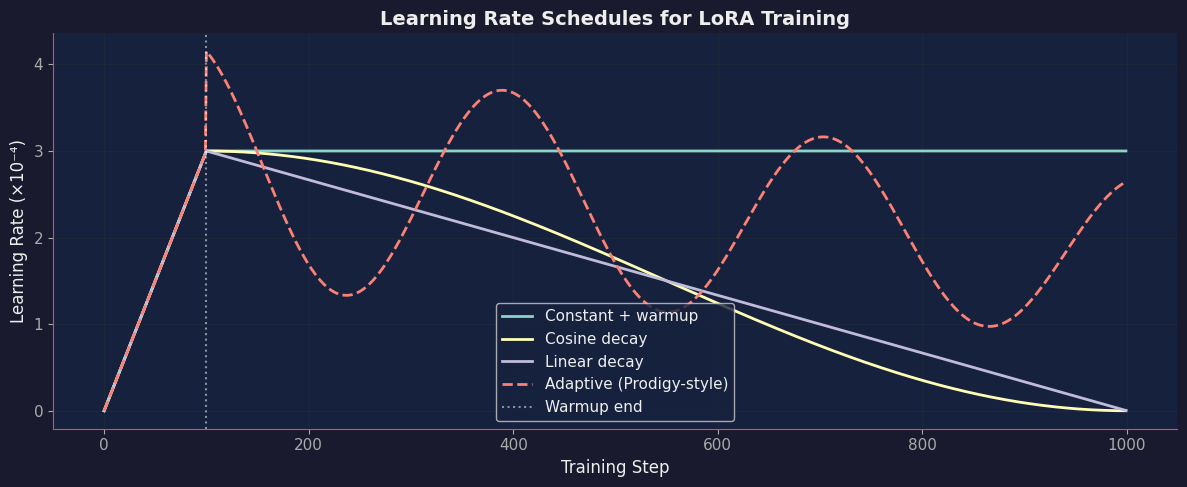


Recommendations:
- Cosine decay: Best for most cases, smooth convergence
- Constant: Good for short training runs (<500 steps)
- Prodigy/adaptive: Useful when optimal LR is unknown


In [13]:
def visualize_lr_schedules():
    """Compare different learning rate schedules for LoRA training."""
    
    total_steps = 1000
    warmup_steps = 100
    base_lr = 3e-4
    
    steps = np.arange(total_steps)
    
    # Constant with warmup
    lr_constant = np.where(
        steps < warmup_steps,
        base_lr * steps / warmup_steps,
        base_lr
    )
    
    # Cosine decay
    lr_cosine = np.where(
        steps < warmup_steps,
        base_lr * steps / warmup_steps,
        base_lr * 0.5 * (1 + np.cos(np.pi * (steps - warmup_steps) / (total_steps - warmup_steps)))
    )
    
    # Linear decay
    lr_linear = np.where(
        steps < warmup_steps,
        base_lr * steps / warmup_steps,
        base_lr * (1 - (steps - warmup_steps) / (total_steps - warmup_steps))
    )
    
    # Prodigy-style adaptive (simplified simulation)
    # In practice, Prodigy adapts based on gradient statistics
    lr_adaptive = base_lr * (1 + 0.5 * np.sin(steps / 50)) * np.exp(-steps / 2000)
    lr_adaptive[:warmup_steps] = base_lr * steps[:warmup_steps] / warmup_steps
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(steps, lr_constant * 1e4, label='Constant + warmup', linewidth=2)
    ax.plot(steps, lr_cosine * 1e4, label='Cosine decay', linewidth=2)
    ax.plot(steps, lr_linear * 1e4, label='Linear decay', linewidth=2)
    ax.plot(steps, lr_adaptive * 1e4, label='Adaptive (Prodigy-style)', linewidth=2, linestyle='--')
    
    ax.axvline(x=warmup_steps, color='white', linestyle=':', alpha=0.5, label='Warmup end')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Learning Rate (×10⁻⁴)')
    ax.set_title('Learning Rate Schedules for LoRA Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nRecommendations:")
    print("- Cosine decay: Best for most cases, smooth convergence")
    print("- Constant: Good for short training runs (<500 steps)")
    print("- Prodigy/adaptive: Useful when optimal LR is unknown")

visualize_lr_schedules()

### 2.4 Batch Size, Gradient Accumulation, and Effective Batch

Memory constraints often limit batch size. Use gradient accumulation to achieve larger effective batches:

$$\text{Effective Batch} = \text{Batch Size} \times \text{Gradient Accumulation Steps} \times \text{Num GPUs}$$

**Trade-offs:**
- Larger effective batch → more stable gradients, but may miss fine-grained features
- Smaller effective batch → noisier gradients, but captures more diversity

**Recommendations for image LoRAs:**
- Style: Effective batch 4-8 (diversity helps)
- Subject: Effective batch 1-4 (consistency matters)
- Concept: Effective batch 2-4

In [14]:
def compute_training_config(
    dataset_size: int,
    target_epochs: float,
    gpu_memory_gb: int,
    model_size_b: float = 4.0,  # Klein Base 4B
) -> Dict:
    """Compute recommended training configuration based on constraints."""
    
    # Memory estimation (rough)
    # bf16 model + optimizer states + activations
    base_memory_gb = model_size_b * 2  # Model weights in bf16
    optimizer_memory_gb = 0.5  # LoRA params + Adam states
    
    # Available for batch
    available_gb = gpu_memory_gb - base_memory_gb - optimizer_memory_gb
    
    # Per-sample memory (rough estimate for 1024x1024)
    per_sample_gb = 2.5  # Activations + gradients
    
    max_batch_size = max(1, int(available_gb / per_sample_gb))
    
    # Recommended effective batch sizes
    recommended_effective_batch = 4
    grad_accum = max(1, recommended_effective_batch // max_batch_size)
    actual_effective_batch = max_batch_size * grad_accum
    
    # Steps calculation
    steps_per_epoch = dataset_size // actual_effective_batch
    total_steps = int(steps_per_epoch * target_epochs)
    
    return {
        'max_batch_size': max_batch_size,
        'grad_accumulation': grad_accum,
        'effective_batch': actual_effective_batch,
        'steps_per_epoch': steps_per_epoch,
        'total_steps': total_steps,
        'estimated_memory_gb': base_memory_gb + optimizer_memory_gb + (max_batch_size * per_sample_gb),
    }

# Example configurations
scenarios = [
    ('Small dataset (50 images)', 50, 10.0, 24),
    ('Medium dataset (200 images)', 200, 5.0, 24),
    ('Large dataset (1000 images)', 1000, 3.0, 24),
    ('Consumer GPU (16GB)', 100, 8.0, 16),
    ('High-end GPU (80GB)', 500, 3.0, 80),
]

print("Training Configuration Recommendations for Klein Base 4B")
print("=" * 80)
print(f"{'Scenario':<35} {'Batch':>6} {'Accum':>6} {'Eff.':>6} {'Steps':>8} {'Mem':>6}")
print("-" * 80)

for name, n_images, epochs, gpu_mem in scenarios:
    config = compute_training_config(n_images, epochs, gpu_mem)
    print(f"{name:<35} {config['max_batch_size']:>6} {config['grad_accumulation']:>6} "
          f"{config['effective_batch']:>6} {config['total_steps']:>8} {config['estimated_memory_gb']:>5.1f}G")

Training Configuration Recommendations for Klein Base 4B
Scenario                             Batch  Accum   Eff.    Steps    Mem
--------------------------------------------------------------------------------
Small dataset (50 images)                6      1      6       80  23.5G
Medium dataset (200 images)              6      1      6      165  23.5G
Large dataset (1000 images)              6      1      6      498  23.5G
Consumer GPU (16GB)                      3      1      3      264  16.0G
High-end GPU (80GB)                     28      1     28       51  78.5G


---
## Part 3: Data Strategies for High-Quality Image LoRAs

### 3.1 Dataset Size Guidelines

The optimal dataset size depends on what you're training:

| LoRA Type | Min Images | Recommended | Max Useful |
|-----------|------------|-------------|------------|
| Single concept | 5-10 | 15-30 | 50 |
| Character/face | 10-20 | 30-50 | 100 |
| Style | 20-50 | 50-200 | 500 |
| Multi-concept | 30-50 per concept | 50-100 per concept | 200 per concept |

**Quality > Quantity**: 20 excellent images beat 200 mediocre ones.

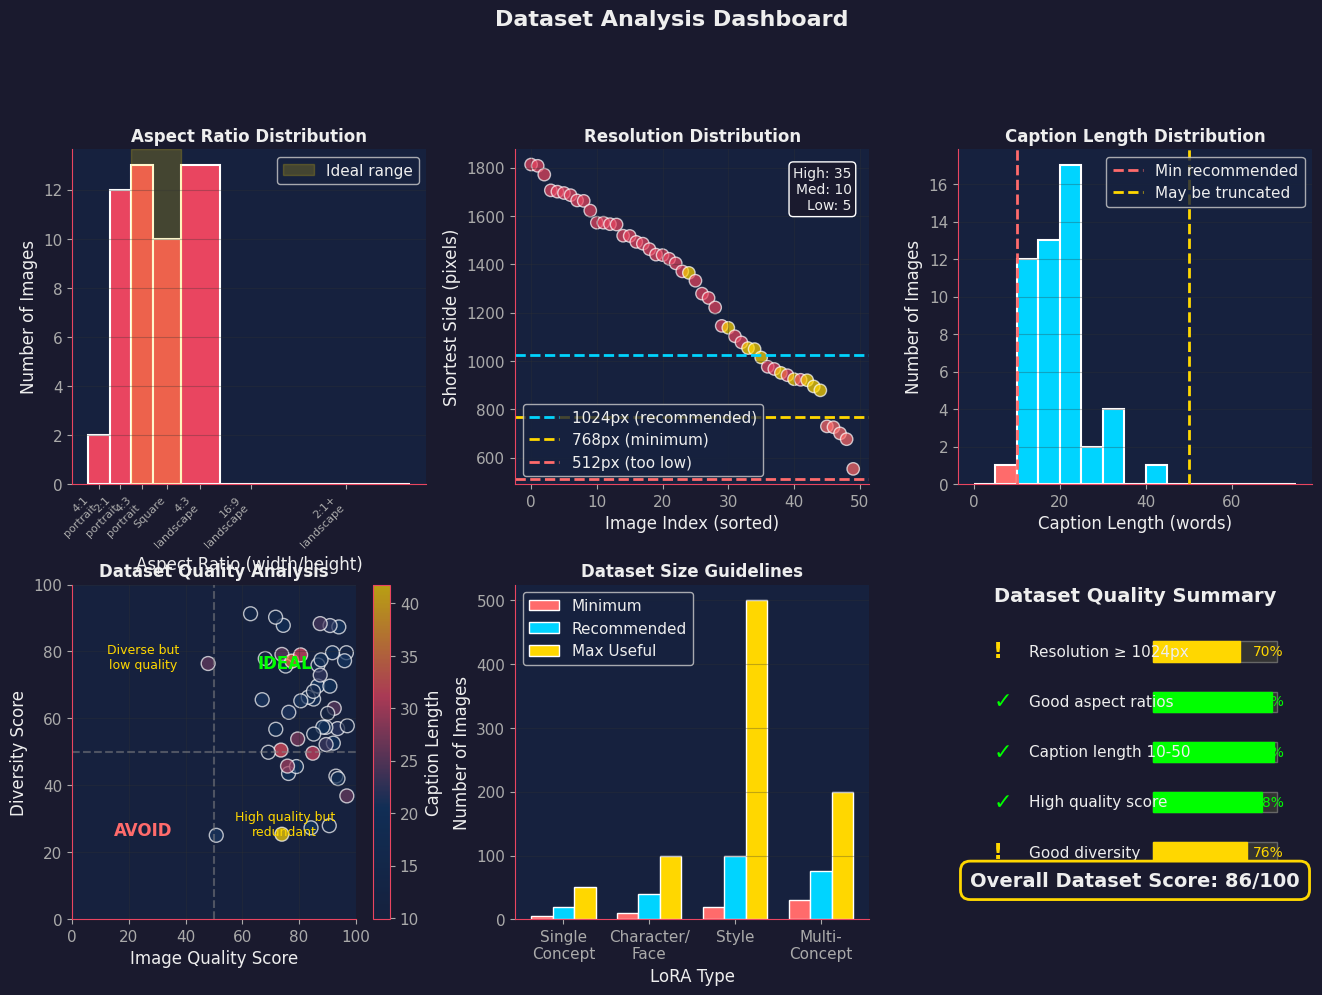

In [15]:
def visualize_dataset_analysis():
    """Visualize dataset characteristics and quality metrics."""
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.25)
    
    np.random.seed(42)
    
    # Simulated dataset properties
    n_images = 50
    
    # Aspect ratios (realistic distribution)
    aspect_ratios = np.concatenate([
        np.random.normal(1.0, 0.1, 20),      # Square-ish
        np.random.normal(1.5, 0.15, 15),     # Landscape
        np.random.normal(0.67, 0.1, 15),     # Portrait
    ])
    
    # Resolutions (width in pixels)
    resolutions = np.concatenate([
        np.random.normal(1500, 200, 30),     # High res
        np.random.normal(1000, 150, 15),     # Medium res
        np.random.normal(700, 100, 5),       # Low res (problematic)
    ])
    
    # Caption lengths (word count)
    caption_lengths = np.random.gamma(5, 3, n_images) + 5
    
    # Image quality scores (simulated)
    quality_scores = np.random.beta(8, 2, n_images) * 100
    
    # Diversity scores (how different from others)
    diversity_scores = np.random.beta(5, 3, n_images) * 100
    
    # Plot 1: Aspect Ratio Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create bucket visualization
    bucket_edges = [0.25, 0.5, 0.75, 1.0, 1.33, 1.78, 2.5, 4.0]
    bucket_labels = ['4:1\nportrait', '2:1\nportrait', '4:3\nportrait', 'Square', 
                    '4:3\nlandscape', '16:9\nlandscape', '2:1+\nlandscape']
    
    counts, bins, patches = ax1.hist(aspect_ratios, bins=bucket_edges, 
                                      color='#e94560', edgecolor='white', linewidth=1.5)
    
    ax1.set_xlabel('Aspect Ratio (width/height)')
    ax1.set_ylabel('Number of Images')
    ax1.set_title('Aspect Ratio Distribution', fontsize=12)
    ax1.set_xticks([(bucket_edges[i] + bucket_edges[i+1])/2 for i in range(len(bucket_edges)-1)])
    ax1.set_xticklabels(bucket_labels, fontsize=8, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add ideal range
    ax1.axvspan(0.75, 1.33, alpha=0.2, color='#ffd700', label='Ideal range')
    ax1.legend()
    
    # Plot 2: Resolution Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    
    colors = ['#e94560' if r >= 1024 else '#ffd700' if r >= 768 else '#ff6b6b' for r in resolutions]
    ax2.scatter(range(len(resolutions)), sorted(resolutions, reverse=True), 
               c=colors, s=80, alpha=0.7, edgecolors='white')
    
    ax2.axhline(y=1024, color='#00d4ff', linestyle='--', linewidth=2, label='1024px (recommended)')
    ax2.axhline(y=768, color='#ffd700', linestyle='--', linewidth=2, label='768px (minimum)')
    ax2.axhline(y=512, color='#ff6b6b', linestyle='--', linewidth=2, label='512px (too low)')
    
    ax2.set_xlabel('Image Index (sorted)')
    ax2.set_ylabel('Shortest Side (pixels)')
    ax2.set_title('Resolution Distribution', fontsize=12)
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    # Count good/bad
    high_res = sum(1 for r in resolutions if r >= 1024)
    med_res = sum(1 for r in resolutions if 768 <= r < 1024)
    low_res = sum(1 for r in resolutions if r < 768)
    ax2.text(0.95, 0.95, f'High: {high_res}\nMed: {med_res}\nLow: {low_res}', 
            transform=ax2.transAxes, fontsize=10, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='#1a1a2e', edgecolor='white'))
    
    # Plot 3: Caption Length Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    
    bins_caption = np.arange(0, 80, 5)
    counts, bins, patches = ax3.hist(caption_lengths, bins=bins_caption, 
                                      color='#00d4ff', edgecolor='white', linewidth=1.5)
    
    # Color by quality
    for patch, left_edge in zip(patches, bins[:-1]):
        if left_edge < 10:
            patch.set_facecolor('#ff6b6b')  # Too short
        elif left_edge > 50:
            patch.set_facecolor('#ffd700')  # May be truncated
        else:
            patch.set_facecolor('#00d4ff')  # Good
    
    ax3.axvline(x=10, color='#ff6b6b', linestyle='--', linewidth=2, label='Min recommended')
    ax3.axvline(x=50, color='#ffd700', linestyle='--', linewidth=2, label='May be truncated')
    
    ax3.set_xlabel('Caption Length (words)')
    ax3.set_ylabel('Number of Images')
    ax3.set_title('Caption Length Distribution', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Quality vs Diversity Scatter
    ax4 = fig.add_subplot(gs[1, 0])
    
    scatter = ax4.scatter(quality_scores, diversity_scores, 
                         c=caption_lengths, cmap=bfl_cmap,
                         s=100, alpha=0.7, edgecolors='white', linewidth=1)
    
    # Quadrant labels
    ax4.axhline(y=50, color='#888', linestyle='--', alpha=0.5)
    ax4.axvline(x=50, color='#888', linestyle='--', alpha=0.5)
    
    ax4.text(75, 75, 'IDEAL', fontsize=12, fontweight='bold', color='#00ff00', ha='center')
    ax4.text(25, 75, 'Diverse but\nlow quality', fontsize=9, color='#ffd700', ha='center')
    ax4.text(75, 25, 'High quality but\nredundant', fontsize=9, color='#ffd700', ha='center')
    ax4.text(25, 25, 'AVOID', fontsize=12, fontweight='bold', color='#ff6b6b', ha='center')
    
    ax4.set_xlabel('Image Quality Score')
    ax4.set_ylabel('Diversity Score')
    ax4.set_title('Dataset Quality Analysis', fontsize=12)
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Caption Length')
    ax4.set_xlim(0, 100)
    ax4.set_ylim(0, 100)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Dataset Size Guidelines
    ax5 = fig.add_subplot(gs[1, 1])
    
    lora_types = ['Single\nConcept', 'Character/\nFace', 'Style', 'Multi-\nConcept']
    min_images = [5, 10, 20, 30]
    rec_images = [20, 40, 100, 75]
    max_useful = [50, 100, 500, 200]
    
    x = np.arange(len(lora_types))
    width = 0.25
    
    bars1 = ax5.bar(x - width, min_images, width, label='Minimum', color='#ff6b6b', edgecolor='white')
    bars2 = ax5.bar(x, rec_images, width, label='Recommended', color='#00d4ff', edgecolor='white')
    bars3 = ax5.bar(x + width, max_useful, width, label='Max Useful', color='#ffd700', edgecolor='white')
    
    ax5.set_xlabel('LoRA Type')
    ax5.set_ylabel('Number of Images')
    ax5.set_title('Dataset Size Guidelines', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels(lora_types)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Quality Checklist Summary
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    # Create a visual checklist
    checklist_items = [
        ('Resolution ≥ 1024px', high_res / n_images * 100),
        ('Good aspect ratios', sum(1 for ar in aspect_ratios if 0.5 <= ar <= 2.0) / n_images * 100),
        ('Caption length 10-50', sum(1 for cl in caption_lengths if 10 <= cl <= 50) / n_images * 100),
        ('High quality score', sum(1 for q in quality_scores if q >= 70) / n_images * 100),
        ('Good diversity', sum(1 for d in diversity_scores if d >= 50) / n_images * 100),
    ]
    
    ax6.text(0.5, 0.95, 'Dataset Quality Summary', fontsize=14, fontweight='bold', 
            ha='center', transform=ax6.transAxes)
    
    y_pos = 0.8
    for item, score in checklist_items:
        # Status icon
        if score >= 80:
            status = '✓'
            color = '#00ff00'
        elif score >= 50:
            status = '!'
            color = '#ffd700'
        else:
            status = '✗'
            color = '#ff6b6b'
        
        ax6.text(0.1, y_pos, status, fontsize=16, fontweight='bold', color=color, 
                transform=ax6.transAxes, va='center')
        ax6.text(0.2, y_pos, f'{item}', fontsize=11, transform=ax6.transAxes, va='center')
        
        # Progress bar
        bar_width = 0.35
        ax6.add_patch(plt.Rectangle((0.55, y_pos - 0.03), bar_width, 0.06, 
                                    transform=ax6.transAxes, facecolor='#333', edgecolor='#666'))
        ax6.add_patch(plt.Rectangle((0.55, y_pos - 0.03), bar_width * score / 100, 0.06, 
                                    transform=ax6.transAxes, facecolor=color, edgecolor=color))
        ax6.text(0.92, y_pos, f'{score:.0f}%', fontsize=10, transform=ax6.transAxes, 
                va='center', ha='right', color=color)
        
        y_pos -= 0.15
    
    # Overall score
    overall = np.mean([score for _, score in checklist_items])
    ax6.text(0.5, 0.1, f'Overall Dataset Score: {overall:.0f}/100', fontsize=14, 
            fontweight='bold', ha='center', transform=ax6.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#1a1a2e', edgecolor='#ffd700', linewidth=2))
    
    plt.suptitle('Dataset Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_dataset_analysis()

In [16]:
def dataset_quality_checklist():
    """Print comprehensive dataset quality checklist."""
    
    checklist = {
        "Image Quality": [
            "High resolution (1024px+ on shortest side)",
            "Sharp focus, no motion blur",
            "Good lighting, minimal noise",
            "No watermarks, text overlays, or artifacts",
            "Consistent aspect ratios (or handle bucketing properly)",
        ],
        "Content Diversity": [
            "Variety of poses/angles (for subjects)",
            "Different backgrounds and contexts",
            "Range of lighting conditions",
            "Multiple compositions (close-up, full body, etc.)",
            "Avoid near-duplicate images",
        ],
        "Caption Quality": [
            "Accurate descriptions of image content",
            "Consistent trigger word usage",
            "Appropriate level of detail",
            "No hallucinated content in captions",
            "Balance between specific and general descriptions",
        ],
        "Dataset Balance": [
            "Even distribution across concepts (if multi-concept)",
            "No single dominant background/setting",
            "Avoid bias toward specific attributes",
            "Include edge cases the model should handle",
        ],
    }
    
    print("Dataset Quality Checklist for Image LoRAs")
    print("=" * 60)
    
    for category, items in checklist.items():
        print(f"\n{category}:")
        for item in items:
            print(f"  □ {item}")

dataset_quality_checklist()

Dataset Quality Checklist for Image LoRAs

Image Quality:
  □ High resolution (1024px+ on shortest side)
  □ Sharp focus, no motion blur
  □ Good lighting, minimal noise
  □ No watermarks, text overlays, or artifacts
  □ Consistent aspect ratios (or handle bucketing properly)

Content Diversity:
  □ Variety of poses/angles (for subjects)
  □ Different backgrounds and contexts
  □ Range of lighting conditions
  □ Multiple compositions (close-up, full body, etc.)
  □ Avoid near-duplicate images

Caption Quality:
  □ Accurate descriptions of image content
  □ Consistent trigger word usage
  □ Appropriate level of detail
  □ No hallucinated content in captions
  □ Balance between specific and general descriptions

Dataset Balance:
  □ Even distribution across concepts (if multi-concept)
  □ No single dominant background/setting
  □ Avoid bias toward specific attributes
  □ Include edge cases the model should handle


### 3.2 Captioning Strategies

Captions are critical for teaching the model when to apply learned concepts:

**Trigger Words:**
- Use a unique, rare token as trigger (e.g., `sks`, `ohwx`, custom string)
- Place trigger consistently (usually at start of caption)
- Trigger should appear in ALL training captions

**Caption Structure:**
```
[trigger] [subject description], [style/quality tags], [background], [technical details]
```

**Example:**
```
sks woman with red hair, portrait photography, soft lighting, studio background, 85mm lens, shallow depth of field
```

In [17]:
from typing import List
import re

class CaptionProcessor:
    """Utilities for processing and validating LoRA training captions."""
    
    def __init__(self, trigger_word: str = "sks"):
        self.trigger_word = trigger_word
    
    def validate_caption(self, caption: str) -> Dict[str, any]:
        """Validate a caption for common issues."""
        issues = []
        
        # Check trigger word
        if self.trigger_word not in caption.lower():
            issues.append(f"Missing trigger word '{self.trigger_word}'")
        
        # Check length
        word_count = len(caption.split())
        if word_count < 5:
            issues.append(f"Caption too short ({word_count} words)")
        elif word_count > 75:
            issues.append(f"Caption very long ({word_count} words), may be truncated")
        
        # Check for problematic patterns
        if re.search(r'\b(image|photo|picture) of\b', caption.lower()):
            issues.append("Contains 'image of' pattern (can reduce quality)")
        
        if re.search(r'http|www\.', caption.lower()):
            issues.append("Contains URL")
        
        return {
            'valid': len(issues) == 0,
            'issues': issues,
            'word_count': word_count,
        }
    
    def suggest_improvements(self, caption: str, image_type: str = "portrait") -> str:
        """Suggest improvements for a caption."""
        suggestions = []
        
        # Trigger word placement
        if self.trigger_word in caption and not caption.lower().startswith(self.trigger_word):
            suggestions.append(f"Consider moving '{self.trigger_word}' to the start")
        
        # Missing common elements
        if 'lighting' not in caption.lower():
            suggestions.append("Consider adding lighting description")
        
        if image_type == "portrait" and not any(x in caption.lower() for x in ['background', 'setting', 'environment']):
            suggestions.append("Consider describing the background")
        
        return suggestions

# Example usage
processor = CaptionProcessor(trigger_word="sks")

test_captions = [
    "sks woman with long brown hair, professional headshot, natural lighting, white background",
    "a photo of a woman",
    "sks person standing in a field at sunset, golden hour, dramatic sky, full body shot, cinematic composition",
    "woman with sks style hair",  # Trigger in wrong position
]

print("Caption Validation Examples")
print("=" * 70)

for caption in test_captions:
    result = processor.validate_caption(caption)
    status = "✓" if result['valid'] else "✗"
    print(f"\n{status} \"{caption[:60]}{'...' if len(caption) > 60 else ''}\"")
    print(f"  Words: {result['word_count']}")
    if result['issues']:
        for issue in result['issues']:
            print(f"  ⚠ {issue}")
    suggestions = processor.suggest_improvements(caption)
    if suggestions:
        for s in suggestions:
            print(f"  → {s}")

Caption Validation Examples

✓ "sks woman with long brown hair, professional headshot, natur..."
  Words: 12

✗ "a photo of a woman"
  Words: 5
  ⚠ Missing trigger word 'sks'
  ⚠ Contains 'image of' pattern (can reduce quality)
  → Consider adding lighting description
  → Consider describing the background

✓ "sks person standing in a field at sunset, golden hour, drama..."
  Words: 17
  → Consider adding lighting description
  → Consider describing the background

✓ "woman with sks style hair"
  Words: 5
  → Consider moving 'sks' to the start
  → Consider adding lighting description
  → Consider describing the background


### 3.3 Image Preprocessing and Bucketing

Diffusion models require specific input dimensions. FLUX.2 uses 16x spatial compression:

**Constraints:**
- Dimensions must be multiples of 16
- Aspect ratios typically 1:8 to 8:1
- Common training resolutions: 512, 768, 1024

**Bucketing Strategy:**
Instead of cropping/resizing all images to one size, group images by similar aspect ratios.

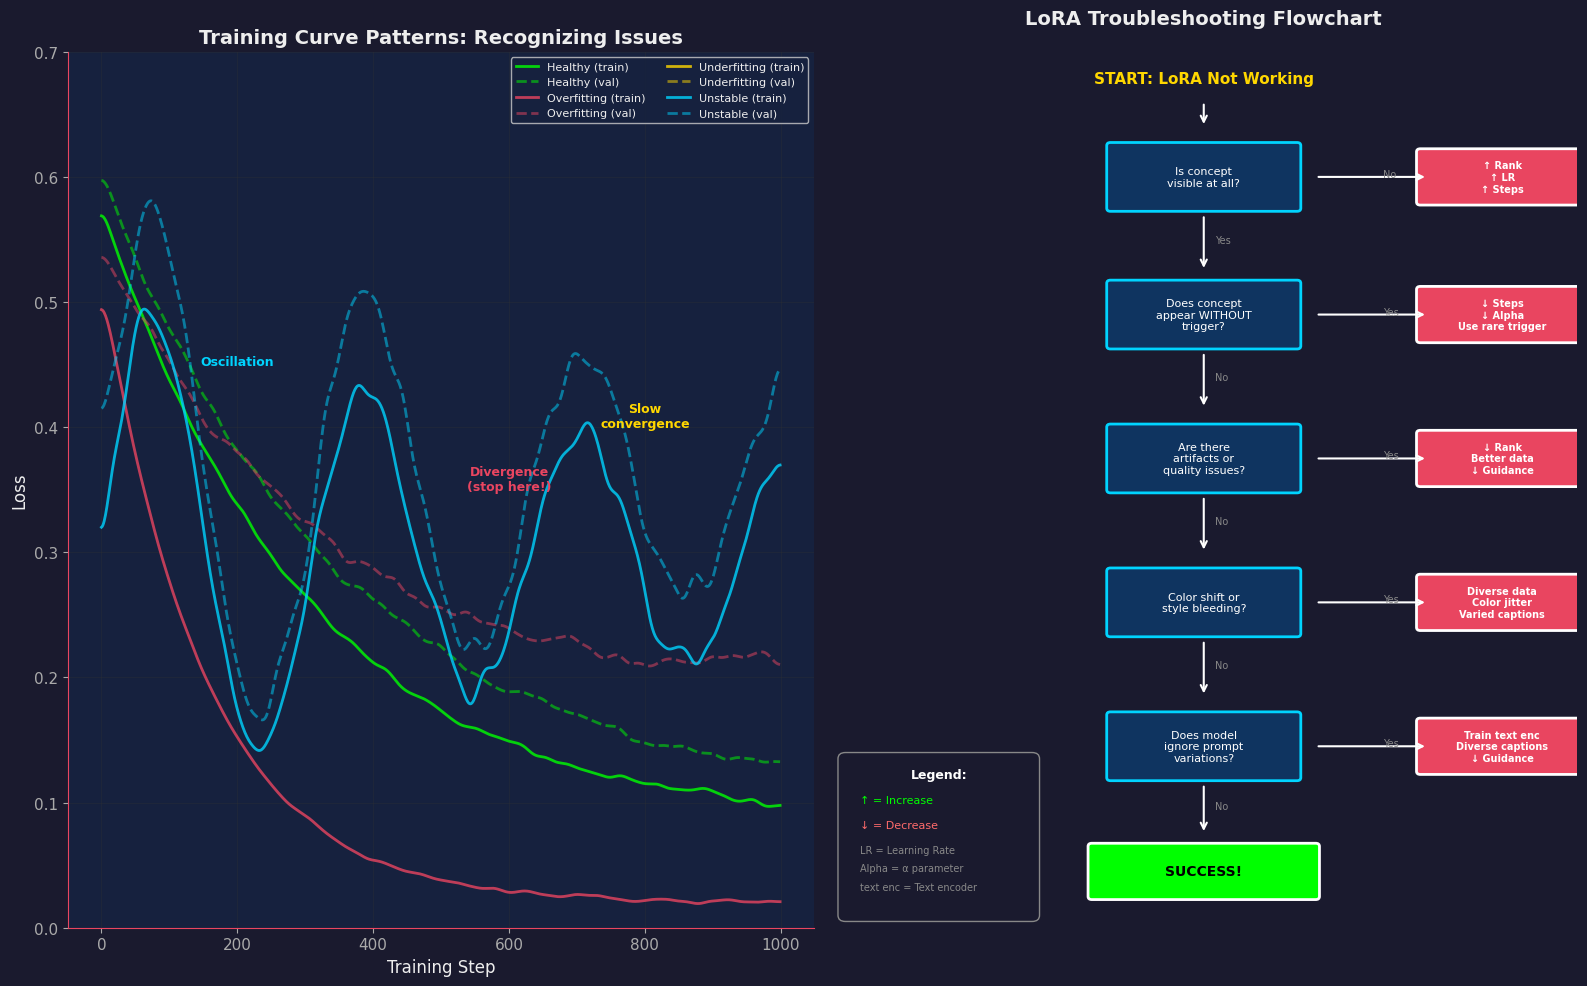

In [18]:
def visualize_failure_mode_diagnostic():
    """Visual diagnostic flowchart for LoRA training issues."""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    # Left: Simulated training curves showing different failure modes
    ax1 = axes[0]
    
    steps = np.arange(1000)
    np.random.seed(42)
    
    # Different training scenarios
    scenarios = {
        'Healthy': {
            'train': 0.5 * np.exp(-steps / 300) + 0.08 + np.random.randn(1000) * 0.01,
            'val': 0.5 * np.exp(-steps / 350) + 0.10 + np.random.randn(1000) * 0.015,
            'color': '#00ff00',
            'style': '-'
        },
        'Overfitting': {
            'train': 0.5 * np.exp(-steps / 150) + 0.02 + np.random.randn(1000) * 0.005,
            'val': 0.5 * np.exp(-steps / 400) + 0.05 * (1 + steps / 400) + np.random.randn(1000) * 0.02,
            'color': '#e94560',
            'style': '-'
        },
        'Underfitting': {
            'train': 0.5 * np.exp(-steps / 3000) + 0.35 + np.random.randn(1000) * 0.02,
            'val': 0.5 * np.exp(-steps / 3500) + 0.38 + np.random.randn(1000) * 0.025,
            'color': '#ffd700',
            'style': '-'
        },
        'Unstable': {
            'train': 0.3 + 0.2 * np.sin(steps / 50) * np.exp(-steps / 1000) + np.random.randn(1000) * 0.05,
            'val': 0.35 + 0.25 * np.sin(steps / 50) * np.exp(-steps / 800) + np.random.randn(1000) * 0.06,
            'color': '#00d4ff',
            'style': '-'
        },
    }
    
    for name, data in scenarios.items():
        # Smooth for visibility
        from scipy.ndimage import gaussian_filter1d
        train_smooth = gaussian_filter1d(data['train'], sigma=10)
        val_smooth = gaussian_filter1d(data['val'], sigma=10)
        
        ax1.plot(steps, train_smooth, data['style'], color=data['color'], 
                linewidth=2, alpha=0.8, label=f'{name} (train)')
        ax1.plot(steps, val_smooth, '--', color=data['color'], 
                linewidth=2, alpha=0.5, label=f'{name} (val)')
    
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Curve Patterns: Recognizing Issues', fontsize=14)
    ax1.legend(loc='upper right', ncol=2, fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 0.7)
    
    # Annotations
    ax1.annotate('Divergence\n(stop here!)', xy=(600, 0.35), fontsize=9, color='#e94560',
                ha='center', fontweight='bold')
    ax1.annotate('Slow\nconvergence', xy=(800, 0.4), fontsize=9, color='#ffd700',
                ha='center', fontweight='bold')
    ax1.annotate('Oscillation', xy=(200, 0.45), fontsize=9, color='#00d4ff',
                ha='center', fontweight='bold')
    
    # Right: Diagnostic flowchart
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 14)
    ax2.axis('off')
    ax2.set_title('LoRA Troubleshooting Flowchart', fontsize=14, pad=20)
    
    def draw_decision(ax, x, y, text, w=2.5, h=1):
        diamond = mpatches.FancyBboxPatch((x - w/2, y - h/2), w, h,
                                          boxstyle="round,pad=0.05",
                                          facecolor='#0f3460', edgecolor='#00d4ff', linewidth=2)
        ax.add_patch(diamond)
        ax.text(x, y, text, ha='center', va='center', fontsize=8, color='white', wrap=True)
    
    def draw_action(ax, x, y, text, w=2.2, h=0.8):
        rect = mpatches.FancyBboxPatch((x - w/2, y - h/2), w, h,
                                       boxstyle="round,pad=0.05",
                                       facecolor='#e94560', edgecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center', fontsize=7, color='white', fontweight='bold')
    
    def draw_arrow(ax, x1, y1, x2, y2, label=''):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='white', lw=1.5))
        if label:
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(mid_x + 0.15, mid_y, label, fontsize=7, color='#888')
    
    # Start
    ax2.text(5, 13.5, 'START: LoRA Not Working', ha='center', fontsize=11, fontweight='bold', color='#ffd700')
    draw_arrow(ax2, 5, 13.2, 5, 12.8)
    
    # Decision 1: Is concept visible?
    draw_decision(ax2, 5, 12, 'Is concept\nvisible at all?')
    draw_arrow(ax2, 5, 11.4, 5, 10.5, 'Yes')
    draw_arrow(ax2, 6.5, 12, 8, 12, 'No')
    draw_action(ax2, 9, 12, '↑ Rank\n↑ LR\n↑ Steps')
    
    # Decision 2: Is it too strong?
    draw_decision(ax2, 5, 9.8, 'Does concept\nappear WITHOUT\ntrigger?')
    draw_arrow(ax2, 5, 9.2, 5, 8.3, 'No')
    draw_arrow(ax2, 6.5, 9.8, 8, 9.8, 'Yes')
    draw_action(ax2, 9, 9.8, '↓ Steps\n↓ Alpha\nUse rare trigger')
    
    # Decision 3: Quality issues?
    draw_decision(ax2, 5, 7.5, 'Are there\nartifacts or\nquality issues?')
    draw_arrow(ax2, 5, 6.9, 5, 6, 'No')
    draw_arrow(ax2, 6.5, 7.5, 8, 7.5, 'Yes')
    draw_action(ax2, 9, 7.5, '↓ Rank\nBetter data\n↓ Guidance')
    
    # Decision 4: Style issues?
    draw_decision(ax2, 5, 5.2, 'Color shift or\nstyle bleeding?')
    draw_arrow(ax2, 5, 4.6, 5, 3.7, 'No')
    draw_arrow(ax2, 6.5, 5.2, 8, 5.2, 'Yes')
    draw_action(ax2, 9, 5.2, 'Diverse data\nColor jitter\nVaried captions')
    
    # Decision 5: Prompt following?
    draw_decision(ax2, 5, 2.9, 'Does model\nignore prompt\nvariations?')
    draw_arrow(ax2, 5, 2.3, 5, 1.5, 'No')
    draw_arrow(ax2, 6.5, 2.9, 8, 2.9, 'Yes')
    draw_action(ax2, 9, 2.9, 'Train text enc\nDiverse captions\n↓ Guidance')
    
    # Success
    ax2.add_patch(mpatches.FancyBboxPatch((3.5, 0.5), 3, 0.8,
                                          boxstyle="round,pad=0.05",
                                          facecolor='#00ff00', edgecolor='white', linewidth=2))
    ax2.text(5, 0.9, 'SUCCESS!', ha='center', va='center', fontsize=10, 
            color='black', fontweight='bold')
    
    # Legend for actions
    ax2.add_patch(mpatches.FancyBboxPatch((0.2, 0.2), 2.5, 2.5,
                                          boxstyle="round,pad=0.1",
                                          facecolor='#1a1a2e', edgecolor='#888', linewidth=1))
    ax2.text(1.45, 2.4, 'Legend:', fontsize=9, fontweight='bold', ha='center', color='white')
    ax2.text(0.4, 2.0, '↑ = Increase', fontsize=8, color='#00ff00')
    ax2.text(0.4, 1.6, '↓ = Decrease', fontsize=8, color='#ff6b6b')
    ax2.text(0.4, 1.2, 'LR = Learning Rate', fontsize=7, color='#888')
    ax2.text(0.4, 0.9, 'Alpha = α parameter', fontsize=7, color='#888')
    ax2.text(0.4, 0.6, 'text enc = Text encoder', fontsize=7, color='#888')
    
    plt.tight_layout()
    plt.show()

# Need scipy for gaussian filter
try:
    from scipy.ndimage import gaussian_filter1d
    visualize_failure_mode_diagnostic()
except ImportError:
    print("Note: scipy required for smooth curves. Install with: pip install scipy")
    print("Skipping visualization...")

In [19]:
def create_aspect_buckets(
    target_pixels: int = 1024 * 1024,
    min_dim: int = 512,
    max_dim: int = 2048,
    step: int = 64,
) -> List[Tuple[int, int]]:
    """Generate aspect ratio buckets for training."""
    buckets = []
    
    for width in range(min_dim, max_dim + 1, step):
        # Calculate height to achieve target pixel count
        height = int(target_pixels / width)
        # Round to multiple of 16
        height = (height // 16) * 16
        
        if min_dim <= height <= max_dim:
            aspect = width / height
            if 0.25 <= aspect <= 4.0:  # Reasonable aspect ratio range
                buckets.append((width, height))
    
    # Remove duplicates and sort
    buckets = list(set(buckets))
    buckets.sort(key=lambda x: x[0] / x[1])
    
    return buckets

def assign_to_bucket(
    image_width: int,
    image_height: int,
    buckets: List[Tuple[int, int]],
) -> Tuple[int, int]:
    """Assign an image to the best matching bucket."""
    image_aspect = image_width / image_height
    
    best_bucket = None
    best_diff = float('inf')
    
    for w, h in buckets:
        bucket_aspect = w / h
        diff = abs(image_aspect - bucket_aspect)
        if diff < best_diff:
            best_diff = diff
            best_bucket = (w, h)
    
    return best_bucket

# Generate buckets for 1MP training
buckets = create_aspect_buckets(target_pixels=1024*1024)

print(f"Generated {len(buckets)} aspect ratio buckets:")
print("\nWidth × Height  │ Aspect Ratio │ Total Pixels")
print("─" * 50)
for w, h in buckets:
    print(f"{w:5d} × {h:<5d}   │    {w/h:.2f}      │  {w*h:,}")

# Example: assign some images
print("\n" + "=" * 50)
print("Example Bucket Assignments:")
test_images = [(1920, 1080), (1080, 1920), (1024, 1024), (800, 1200), (4000, 3000)]
for w, h in test_images:
    bucket = assign_to_bucket(w, h, buckets)
    print(f"  {w}×{h} → {bucket[0]}×{bucket[1]} (aspect: {w/h:.2f} → {bucket[0]/bucket[1]:.2f})")

Generated 25 aspect ratio buckets:

Width × Height  │ Aspect Ratio │ Total Pixels
──────────────────────────────────────────────────
  512 × 2048    │    0.25      │  1,048,576
  576 × 1808    │    0.32      │  1,041,408
  640 × 1632    │    0.39      │  1,044,480
  704 × 1488    │    0.47      │  1,047,552
  768 × 1360    │    0.56      │  1,044,480
  832 × 1248    │    0.67      │  1,038,336
  896 × 1168    │    0.77      │  1,046,528
  960 × 1088    │    0.88      │  1,044,480
 1024 × 1024    │    1.00      │  1,048,576
 1088 × 960     │    1.13      │  1,044,480
 1152 × 896     │    1.29      │  1,032,192
 1216 × 848     │    1.43      │  1,031,168
 1280 × 816     │    1.57      │  1,044,480
 1344 × 768     │    1.75      │  1,032,192
 1408 × 736     │    1.91      │  1,036,288
 1472 × 704     │    2.09      │  1,036,288
 1536 × 672     │    2.29      │  1,032,192
 1600 × 640     │    2.50      │  1,024,000
 1664 × 624     │    2.67      │  1,038,336
 1728 × 592     │    2.92      

### 3.4 Augmentation Strategies

Unlike classification tasks, image generation LoRAs need careful augmentation:

**Safe Augmentations:**
- Horizontal flip (for non-asymmetric subjects)
- Minor color jitter (±5%)
- Small random crops (95-100% of image)

**Avoid:**
- Rotation (unless training for rotated content)
- Heavy color changes (alters style learning)
- Aggressive crops (loses composition)
- Noise injection (model already learns denoising)

In [20]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class LoRAAugmentation:
    """Conservative augmentation pipeline for LoRA training."""
    
    def __init__(
        self,
        enable_flip: bool = True,
        flip_prob: float = 0.5,
        enable_color_jitter: bool = False,
        color_jitter_strength: float = 0.05,
        enable_random_crop: bool = False,
        crop_scale: Tuple[float, float] = (0.95, 1.0),
    ):
        self.enable_flip = enable_flip
        self.flip_prob = flip_prob
        self.enable_color_jitter = enable_color_jitter
        self.enable_random_crop = enable_random_crop
        
        transforms = []
        
        if enable_random_crop:
            transforms.append(
                T.RandomResizedCrop(
                    size=(1024, 1024),  # Will be adjusted per-bucket
                    scale=crop_scale,
                    ratio=(0.95, 1.05),
                    interpolation=T.InterpolationMode.LANCZOS,
                )
            )
        
        if enable_color_jitter:
            transforms.append(
                T.ColorJitter(
                    brightness=color_jitter_strength,
                    contrast=color_jitter_strength,
                    saturation=color_jitter_strength,
                    hue=color_jitter_strength / 2,
                )
            )
        
        self.transform = T.Compose(transforms) if transforms else None
    
    def __call__(self, image: torch.Tensor, caption: str) -> Tuple[torch.Tensor, str]:
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Random horizontal flip
        if self.enable_flip and torch.rand(1).item() < self.flip_prob:
            image = TF.hflip(image)
            # Optionally update caption for directional terms
            caption = self._flip_caption(caption)
        
        return image, caption
    
    def _flip_caption(self, caption: str) -> str:
        """Swap left/right in caption when flipping."""
        swaps = [
            ('left', 'right'),
            ('Left', 'Right'),
        ]
        for a, b in swaps:
            caption = caption.replace(a, '__TEMP__').replace(b, a).replace('__TEMP__', b)
        return caption

# Recommended configurations by LoRA type
augmentation_configs = {
    'style': LoRAAugmentation(
        enable_flip=True,
        enable_color_jitter=False,  # Preserve style colors
        enable_random_crop=True,
    ),
    'character': LoRAAugmentation(
        enable_flip=False,  # Faces are often asymmetric
        enable_color_jitter=False,
        enable_random_crop=False,
    ),
    'object': LoRAAugmentation(
        enable_flip=True,
        enable_color_jitter=True,
        color_jitter_strength=0.03,
        enable_random_crop=True,
    ),
}

print("Recommended Augmentation Configurations:")
print("=" * 50)
for name, config in augmentation_configs.items():
    print(f"\n{name.upper()} LoRA:")
    print(f"  Horizontal flip: {config.enable_flip}")
    print(f"  Color jitter: {config.enable_color_jitter}")
    print(f"  Random crop: {config.enable_random_crop}")

ModuleNotFoundError: No module named 'torchvision'

---
## Part 4: Diagnosing Common Failure Modes

### 4.1 Overfitting Signatures

Overfitting in image LoRAs manifests differently than in classification:

**Symptoms:**
1. **Exact reproduction**: Generated images look identical to training images
2. **Background bleeding**: Training backgrounds appear in unrelated prompts
3. **Pose locking**: Subject always appears in same pose(s)
4. **Style collapse**: All outputs have identical lighting/composition
5. **Prompt ignorance**: Model ignores parts of the prompt

In [21]:
def diagnose_overfitting(metrics: Dict) -> List[str]:
    """
    Diagnose potential overfitting from training metrics.
    
    Expected metrics dict:
    - train_loss: List of training losses
    - val_loss: List of validation losses (if available)
    - clip_similarity: Similarity between generated and training images
    - prompt_adherence: How well outputs match prompts
    """
    diagnoses = []
    
    train_loss = metrics.get('train_loss', [])
    val_loss = metrics.get('val_loss', [])
    
    if len(train_loss) > 10:
        # Check for loss collapse
        final_loss = np.mean(train_loss[-10:])
        initial_loss = np.mean(train_loss[:10])
        
        if final_loss < 0.01:
            diagnoses.append("⚠ Loss collapsed to near-zero: likely severe overfitting")
        
        if initial_loss > 0 and final_loss / initial_loss < 0.1:
            diagnoses.append("⚠ Loss decreased >90%: may be overfitting")
    
    # Validation divergence
    if len(val_loss) > 10 and len(train_loss) > 10:
        train_trend = np.polyfit(range(len(train_loss)), train_loss, 1)[0]
        val_trend = np.polyfit(range(len(val_loss)), val_loss, 1)[0]
        
        if train_trend < 0 and val_trend > 0:
            diagnoses.append("⚠ Train/val divergence: classic overfitting pattern")
    
    # CLIP similarity (if available)
    clip_sim = metrics.get('clip_similarity', None)
    if clip_sim is not None and clip_sim > 0.95:
        diagnoses.append("⚠ Very high CLIP similarity to training: memorization likely")
    
    # Prompt adherence
    prompt_score = metrics.get('prompt_adherence', None)
    if prompt_score is not None and prompt_score < 0.3:
        diagnoses.append("⚠ Low prompt adherence: model may be ignoring text conditioning")
    
    if not diagnoses:
        diagnoses.append("✓ No obvious overfitting indicators in metrics")
    
    return diagnoses

# Example diagnosis
example_metrics = {
    'train_loss': [0.5, 0.3, 0.2, 0.15, 0.1, 0.08, 0.05, 0.03, 0.02, 0.01, 0.008, 0.005],
    'val_loss': [0.5, 0.35, 0.3, 0.28, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
    'clip_similarity': 0.92,
    'prompt_adherence': 0.45,
}

print("Overfitting Diagnosis Example")
print("=" * 50)
for diagnosis in diagnose_overfitting(example_metrics):
    print(diagnosis)

Overfitting Diagnosis Example
⚠ Train/val divergence: classic overfitting pattern


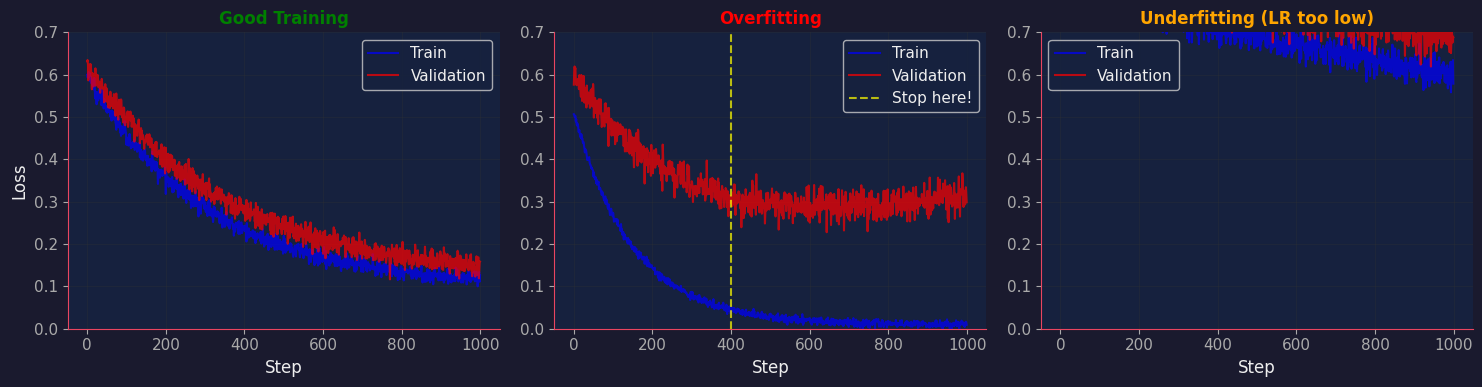

In [22]:
def visualize_overfitting_curve():
    """Visualize typical overfitting patterns in LoRA training."""
    
    steps = np.arange(1000)
    
    # Simulated loss curves
    # Good training
    train_good = 0.5 * np.exp(-steps / 300) + 0.1 + np.random.randn(1000) * 0.01
    val_good = 0.5 * np.exp(-steps / 350) + 0.12 + np.random.randn(1000) * 0.015
    
    # Overfitting
    train_overfit = 0.5 * np.exp(-steps / 150) + 0.01 + np.random.randn(1000) * 0.005
    val_overfit = 0.5 * np.exp(-steps / 300) + 0.1 * (1 + steps / 500) + np.random.randn(1000) * 0.02
    
    # Underfitting (learning rate too low)
    train_underfit = 0.5 * np.exp(-steps / 2000) + 0.3 + np.random.randn(1000) * 0.02
    val_underfit = 0.5 * np.exp(-steps / 2500) + 0.35 + np.random.randn(1000) * 0.025
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Good training
    ax1 = axes[0]
    ax1.plot(steps, train_good, 'b-', alpha=0.7, label='Train')
    ax1.plot(steps, val_good, 'r-', alpha=0.7, label='Validation')
    ax1.set_title('Good Training', fontsize=12, fontweight='bold', color='green')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 0.7)
    
    # Overfitting
    ax2 = axes[1]
    ax2.plot(steps, train_overfit, 'b-', alpha=0.7, label='Train')
    ax2.plot(steps, val_overfit, 'r-', alpha=0.7, label='Validation')
    ax2.axvline(x=400, color='yellow', linestyle='--', alpha=0.7, label='Stop here!')
    ax2.set_title('Overfitting', fontsize=12, fontweight='bold', color='red')
    ax2.set_xlabel('Step')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 0.7)
    
    # Underfitting
    ax3 = axes[2]
    ax3.plot(steps, train_underfit, 'b-', alpha=0.7, label='Train')
    ax3.plot(steps, val_underfit, 'r-', alpha=0.7, label='Validation')
    ax3.set_title('Underfitting (LR too low)', fontsize=12, fontweight='bold', color='orange')
    ax3.set_xlabel('Step')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 0.7)
    
    plt.tight_layout()
    plt.show()

visualize_overfitting_curve()

### 4.2 Quality vs. Flexibility Trade-off

There's an inherent tension between:
- **Fidelity**: How well the LoRA captures the target concept
- **Flexibility**: How well it generalizes to new contexts

**Tuning this trade-off:**

| Parameter | More Fidelity | More Flexibility |
|-----------|---------------|------------------|
| Rank | Higher (32-64) | Lower (8-16) |
| Learning rate | Higher | Lower |
| Training steps | More | Fewer |
| Alpha/Rank ratio | Higher | Lower |
| Caption detail | Less specific | More specific |
| Dataset diversity | Less | More |

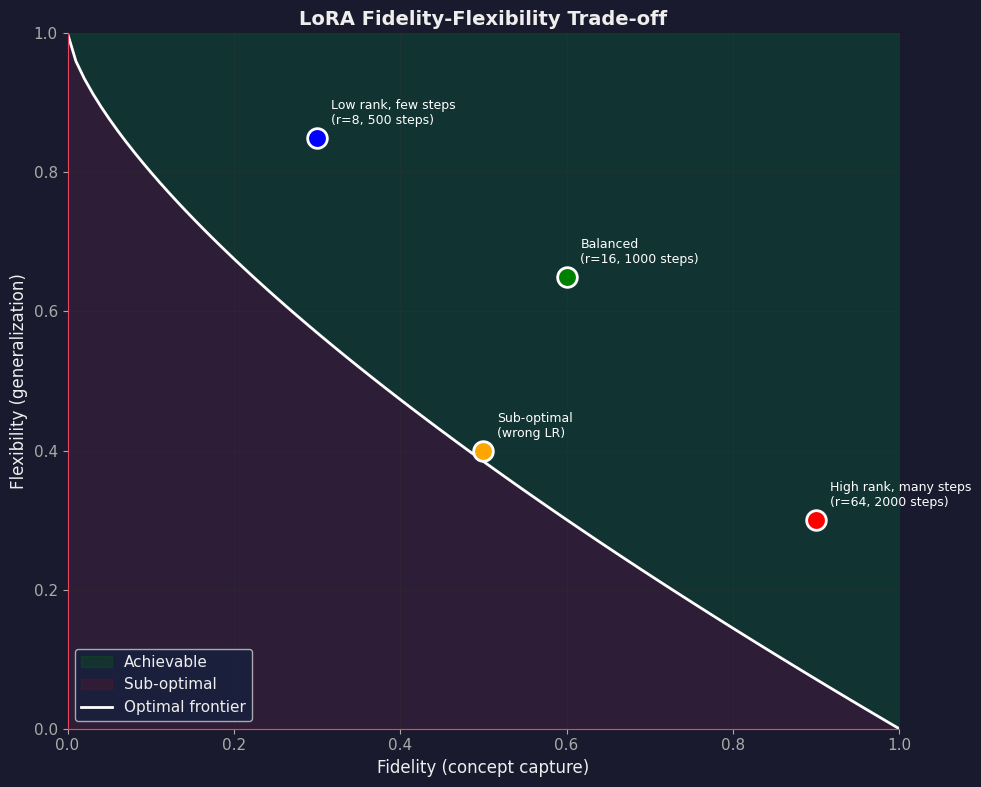

In [23]:
def plot_fidelity_flexibility_tradeoff():
    """Visualize the fidelity-flexibility trade-off space."""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create regions
    x = np.linspace(0, 1, 100)
    
    # Pareto frontier (theoretical optimal trade-off)
    pareto = 1 - x**0.7
    
    # Plot regions
    ax.fill_between(x, pareto, 1, alpha=0.2, color='green', label='Achievable')
    ax.fill_between(x, 0, pareto, alpha=0.1, color='red', label='Sub-optimal')
    ax.plot(x, pareto, 'w-', linewidth=2, label='Optimal frontier')
    
    # Plot example configurations
    configs = [
        (0.9, 0.3, 'High rank, many steps\n(r=64, 2000 steps)', 'red'),
        (0.3, 0.85, 'Low rank, few steps\n(r=8, 500 steps)', 'blue'),
        (0.6, 0.65, 'Balanced\n(r=16, 1000 steps)', 'green'),
        (0.5, 0.4, 'Sub-optimal\n(wrong LR)', 'orange'),
    ]
    
    for fidelity, flexibility, label, color in configs:
        ax.scatter(fidelity, flexibility, s=200, c=color, zorder=5, edgecolors='white', linewidth=2)
        ax.annotate(label, (fidelity, flexibility), 
                   textcoords="offset points", xytext=(10, 10),
                   fontsize=9, color='white')
    
    ax.set_xlabel('Fidelity (concept capture)', fontsize=12)
    ax.set_ylabel('Flexibility (generalization)', fontsize=12)
    ax.set_title('LoRA Fidelity-Flexibility Trade-off', fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_fidelity_flexibility_tradeoff()

### 4.3 Common Failure Modes and Solutions

| Failure Mode | Symptoms | Likely Cause | Solution |
|--------------|----------|--------------|----------|
| **Concept not learned** | No visible change | Rank too low, LR too low, too few steps | Increase rank/LR/steps |
| **Concept bleeds everywhere** | Concept appears without trigger | Trigger word too common, overfitting | Use rarer trigger, reduce steps |
| **Color/style shift** | All outputs have same tint | Dataset color bias | Add color diversity or jitter |
| **Anatomical errors** | Wrong proportions, extra limbs | Dataset quality issues | Curate dataset, reduce rank |
| **Text ignored** | Prompts don't affect output | Text encoder undertrained or frozen | Train text encoder LoRA (carefully) |
| **Artifacts at edges** | Noise/blur at image boundaries | Training resolution mismatch | Match inference resolution |
| **Mode collapse** | All outputs look same | Overfitting, low diversity | More data, lower LR, regularization |

In [ ]:
class LoRADebugger:
    """Interactive debugging tool for LoRA training issues."""
    
    def __init__(self):
        self.failure_modes = {
            'concept_not_learned': {
                'symptoms': ['No visible change from base model', 'Trigger word ignored'],
                'causes': ['Rank too low', 'Learning rate too low', 'Too few training steps', 'Trigger word not in captions'],
                'solutions': [
                    'Increase rank (try 32 or 64)',
                    'Increase learning rate (try 5e-4)',
                    'Train for more steps (try 2x current)',
                    'Verify trigger word in ALL captions',
                ],
            },
            'concept_bleeds': {
                'symptoms': ['Concept appears without using trigger', 'Style affects all generations'],
                'causes': ['Trigger word too common', 'Severe overfitting', 'Alpha too high'],
                'solutions': [
                    'Use a unique trigger (sks, ohwx, etc.)',
                    'Reduce training steps',
                    'Lower alpha/rank ratio',
                    'Add regularization images',
                ],
            },
            'color_shift': {
                'symptoms': ['Consistent color tint on all outputs', 'Wrong white balance'],
                'causes': ['Dataset has uniform lighting/color', 'Overfitting to dataset bias'],
                'solutions': [
                    'Add images with varied lighting',
                    'Apply mild color jitter augmentation',
                    'Include color descriptions in captions',
                ],
            },
            'anatomical_errors': {
                'symptoms': ['Wrong proportions', 'Extra limbs', 'Deformed features'],
                'causes': ['Low quality training images', 'Rank too high causing memorization', 'Dataset too small'],
                'solutions': [
                    'Curate dataset for quality',
                    'Reduce rank',
                    'Add more diverse training images',
                    'Use regularization/prior preservation',
                ],
            },
            'prompt_ignored': {
                'symptoms': ['Prompt variations don\'t change output', 'Only trigger word matters'],
                'causes': ['Text encoder not trained', 'Severe overfitting', 'Captions too similar'],
                'solutions': [
                    'Train text encoder LoRA (with low LR)',
                    'Reduce training steps',
                    'Use more diverse captions',
                    'Lower guidance scale at inference',
                ],
            },
        }
    
    def diagnose(self, observed_symptoms: List[str]) -> Dict:
        """Match observed symptoms to failure modes."""
        matches = []
        
        for mode, info in self.failure_modes.items():
            symptom_match = sum(
                1 for s in observed_symptoms 
                if any(symptom.lower() in s.lower() for symptom in info['symptoms'])
            )
            if symptom_match > 0:
                matches.append((mode, symptom_match, info))
        
        matches.sort(key=lambda x: x[1], reverse=True)
        return matches
    
    def print_diagnosis(self, observed_symptoms: List[str]):
        """Print diagnostic report."""
        matches = self.diagnose(observed_symptoms)
        
        print("LoRA Diagnostic Report")
        print("=" * 60)
        print(f"\nObserved symptoms:")
        for s in observed_symptoms:
            print(f"  • {s}")
        
        if not matches:
            print("\nNo matching failure modes found.")
            return
        
        print(f"\nPotential issues (ranked by match):")
        for mode, score, info in matches[:3]:
            print(f"\n{'─' * 60}")
            print(f"\n📋 {mode.replace('_', ' ').title()} (match score: {score})")
            print(f"\nPossible causes:")
            for cause in info['causes']:
                print(f"  • {cause}")
            print(f"\nRecommended solutions:")
            for i, solution in enumerate(info['solutions'], 1):
                print(f"  {i}. {solution}")

# Example usage
debugger = LoRADebugger()

# Simulate user-reported symptoms
symptoms = [
    "The concept appears even when I don't use the trigger word",
    "All my generations have a blue tint",
]

debugger.print_diagnosis(symptoms)

### 4.4 Validation and Testing Protocol

Systematic testing is essential for quality LoRAs:

In [ ]:
def generate_test_prompts(trigger: str, concept_type: str = "character") -> List[Dict]:
    """
    Generate a comprehensive test suite for LoRA validation.
    
    Tests:
    1. Basic concept recall
    2. Context variation
    3. Style transfer
    4. Composition
    5. Negative (without trigger)
    """
    
    test_suite = {
        "character": [
            # Basic recall
            {"category": "Basic", "prompt": f"{trigger} person, portrait, neutral background", "expect": "concept visible"},
            {"category": "Basic", "prompt": f"{trigger} person, full body shot", "expect": "concept visible"},
            
            # Context variation
            {"category": "Context", "prompt": f"{trigger} person in a forest, natural lighting", "expect": "concept + forest"},
            {"category": "Context", "prompt": f"{trigger} person in a city at night, neon lights", "expect": "concept + urban"},
            {"category": "Context", "prompt": f"{trigger} person on a beach, sunset", "expect": "concept + beach"},
            
            # Style transfer
            {"category": "Style", "prompt": f"{trigger} person, oil painting style", "expect": "concept + painting style"},
            {"category": "Style", "prompt": f"{trigger} person, anime style", "expect": "concept + anime"},
            {"category": "Style", "prompt": f"{trigger} person, black and white photography", "expect": "concept + B&W"},
            
            # Composition
            {"category": "Composition", "prompt": f"{trigger} person holding a cup of coffee", "expect": "concept + object interaction"},
            {"category": "Composition", "prompt": f"two people, one is {trigger} person", "expect": "concept + another person"},
            
            # Negative tests (should NOT show concept)
            {"category": "Negative", "prompt": "a person, portrait, neutral background", "expect": "NO concept (baseline)"},
            {"category": "Negative", "prompt": "a beautiful landscape, mountains", "expect": "NO concept"},
        ],
        "style": [
            # Basic recall
            {"category": "Basic", "prompt": f"{trigger} style, a portrait of a woman", "expect": "style applied"},
            {"category": "Basic", "prompt": f"{trigger} style, a landscape", "expect": "style applied"},
            
            # Subject variation
            {"category": "Subject", "prompt": f"{trigger} style, a cat sitting on a windowsill", "expect": "style + cat"},
            {"category": "Subject", "prompt": f"{trigger} style, a futuristic city", "expect": "style + city"},
            {"category": "Subject", "prompt": f"{trigger} style, abstract shapes", "expect": "style + abstract"},
            
            # Negative
            {"category": "Negative", "prompt": "a portrait of a woman, photorealistic", "expect": "NO style (baseline)"},
        ],
    }
    
    return test_suite.get(concept_type, test_suite["character"])

# Generate test suite
test_prompts = generate_test_prompts(trigger="sks", concept_type="character")

print("LoRA Validation Test Suite")
print("=" * 70)

current_category = None
for i, test in enumerate(test_prompts, 1):
    if test['category'] != current_category:
        current_category = test['category']
        print(f"\n{current_category.upper()} TESTS:")
        print("-" * 40)
    
    print(f"  {i}. {test['prompt'][:50]}...")
    print(f"     Expected: {test['expect']}")

---
## Part 5: Putting It All Together — Training Recipe

### 5.1 Recommended Configuration for Klein Base 4B

In [ ]:
@dataclass
class TrainingConfig:
    """Complete training configuration for Klein Base 4B LoRA."""
    
    # Model
    model_name: str = "flux.2-klein-base-4b"
    
    # LoRA architecture
    lora_rank: int = 16
    lora_alpha: float = 16.0
    lora_dropout: float = 0.0
    target_modules: List[str] = None  # Set in __post_init__
    
    # Training
    learning_rate: float = 3e-4
    lr_scheduler: str = "cosine"
    lr_warmup_ratio: float = 0.05
    
    batch_size: int = 1
    gradient_accumulation_steps: int = 4
    max_train_steps: int = 1000
    
    # Optimization
    optimizer: str = "adamw"  # or "prodigy" for adaptive
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0
    
    # Data
    resolution: int = 1024
    enable_bucket: bool = True
    
    # Regularization
    prior_preservation: bool = False
    prior_loss_weight: float = 1.0
    
    # Checkpointing
    save_every_n_steps: int = 200
    
    def __post_init__(self):
        if self.target_modules is None:
            self.target_modules = [
                # Attention projections
                ".*\.qkv$",
                ".*\.proj$",
            ]
    
    def to_dict(self) -> Dict:
        return {
            'model': {
                'name': self.model_name,
            },
            'lora': {
                'rank': self.lora_rank,
                'alpha': self.lora_alpha,
                'dropout': self.lora_dropout,
                'target_modules': self.target_modules,
            },
            'training': {
                'learning_rate': self.learning_rate,
                'lr_scheduler': self.lr_scheduler,
                'lr_warmup_ratio': self.lr_warmup_ratio,
                'batch_size': self.batch_size,
                'gradient_accumulation_steps': self.gradient_accumulation_steps,
                'max_train_steps': self.max_train_steps,
                'optimizer': self.optimizer,
                'weight_decay': self.weight_decay,
                'max_grad_norm': self.max_grad_norm,
            },
            'data': {
                'resolution': self.resolution,
                'enable_bucket': self.enable_bucket,
            },
        }

# Preset configurations
presets = {
    'style_quick': TrainingConfig(
        lora_rank=8,
        lora_alpha=8,
        learning_rate=1e-4,
        max_train_steps=500,
    ),
    'character_balanced': TrainingConfig(
        lora_rank=16,
        lora_alpha=16,
        learning_rate=3e-4,
        max_train_steps=1000,
    ),
    'subject_detailed': TrainingConfig(
        lora_rank=32,
        lora_alpha=32,
        learning_rate=2e-4,
        max_train_steps=1500,
        prior_preservation=True,
    ),
}

import json

print("Training Configuration Presets for Klein Base 4B")
print("=" * 60)

for name, config in presets.items():
    print(f"\n### {name.upper()} ###")
    print(json.dumps(config.to_dict(), indent=2))

### 5.2 Training Loop Pseudocode

Here's the essential training loop structure for reference:

In [ ]:
def training_loop_pseudocode():
    """
    Pseudocode for LoRA training on Klein Base.
    This is illustrative - actual implementation requires full training infrastructure.
    """
    
    pseudocode = '''
# 1. Load models
model = load_klein_base_4b()           # Frozen base model
ae = load_autoencoder()                 # VAE for latent encoding
text_encoder = load_text_encoder()      # Qwen3 for Klein

# 2. Inject LoRA layers
lora_config = LoRAConfig(rank=16, alpha=16, target_modules=["qkv", "proj"])
model = inject_lora(model, lora_config)  # Only LoRA params are trainable

# 3. Setup optimizer (only for LoRA params)
lora_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(lora_params, lr=3e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=max_steps)

# 4. Training loop
for step in range(max_steps):
    # Get batch
    images, captions = dataloader.get_batch()
    
    # Encode images to latent space
    with torch.no_grad():
        latents = ae.encode(images)     # (B, 128, H/16, W/16)
    
    # Encode text
    with torch.no_grad():
        text_embeddings = text_encoder(captions)  # (B, seq_len, 7680)
    
    # Sample timesteps uniformly
    t = torch.rand(batch_size, device=device)  # Flow matching: t ∈ [0, 1]
    
    # Sample noise
    noise = torch.randn_like(latents)
    
    # Create noisy latents (linear interpolation for flow matching)
    noisy_latents = (1 - t) * latents + t * noise
    
    # Predict velocity
    velocity_pred = model(
        x=noisy_latents,
        timesteps=t,
        ctx=text_embeddings,
        guidance=4.0,
    )
    
    # Target velocity (for flow matching)
    velocity_target = noise - latents
    
    # Loss
    loss = F.mse_loss(velocity_pred, velocity_target)
    
    # Backward
    loss.backward()
    
    # Gradient accumulation
    if (step + 1) % grad_accum_steps == 0:
        torch.nn.utils.clip_grad_norm_(lora_params, max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    # Logging
    if step % log_every == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")
    
    # Save checkpoint
    if step % save_every == 0:
        save_lora_weights(model, f"checkpoint-{step}.safetensors")

# 5. Save final model
save_lora_weights(model, "final_lora.safetensors")
'''
    
    print("Training Loop Pseudocode for Klein Base 4B LoRA")
    print("=" * 60)
    print(pseudocode)

training_loop_pseudocode()

---
## Summary: Key Takeaways

### LoRA Mechanics in Diffusion Models
1. LoRA must work across ALL timesteps — it's not a single-pass adaptation
2. CFG amplifies LoRA effects — higher guidance = stronger LoRA influence
3. Flow matching provides smoother gradients than DDPM

### Hyperparameter Selection
1. **Rank**: 8-16 for style, 16-32 for subjects, 32-64 for complex concepts
2. **Alpha**: Start with α = r, adjust based on results
3. **Learning rate**: 1e-4 to 5e-4 (higher than full fine-tuning)
4. **Target modules**: QKV + output projections as baseline, add MLP for more capacity

### Data Strategy
1. Quality > quantity — 20 excellent images beat 200 mediocre ones
2. Use unique trigger words consistently
3. Diverse captions prevent overfitting to specific descriptions
4. Conservative augmentation — avoid heavy transforms

### Diagnosing Issues
1. Watch for train/val divergence (classic overfitting)
2. Test with and without trigger words
3. Vary context, style, and composition in test prompts
4. Lower guidance at inference if LoRA effect is too strong

---
## References and Further Reading

1. **LoRA: Low-Rank Adaptation of Large Language Models** — Hu et al., 2021
2. **Flow Matching for Generative Modeling** — Lipman et al., 2022
3. **Denoising Diffusion Probabilistic Models** — Ho et al., 2020
4. **Classifier-Free Diffusion Guidance** — Ho & Salimans, 2022
5. **FLUX.2 Technical Documentation** — Black Forest Labs

---

*Workshop materials prepared for Black Forest Labs*